# git add! - part 1

Problem statement:

> My friend is on the job market. However, they keep wasting time applying for fraudulent job postings. They have asked me to use my data skills to filter out fake postings and save them effort.
> They have mentioned that job postings are abundant, so they would prefer my solution to risk filtering out real posts if it decreases the number of fraudulent posts they apply to.
> I have access to a dataset consisting of approximately 18'000 job postings, containing both real and fake jobs.


## Story published with Jupyter2Hashnode

Have you ever struggled to convert a Jupyter Notebook into a compelling Hashnode story? If so, you're not alone. It can be a daunting task, but fortunately, there's a tool that can simplify the process: Jupyter2Hashnode.

With Jupyter2Hashnode, you can convert Jupyter Notebooks into Hashnode stories with just a single command. The tool compresses images, uploads them to the Hashnode server, updates image URLs in the markdown file, and finally, publishes the story article. It's an effortless way to transform your data analysis or code tutorials into a polished and engaging format.

If you're interested in learning more about Jupyter2Hashnode, there's a detailed guide available on Hashnode (https://tiagopatriciosantos.hashnode.dev/jupyter2hashnode-an-effortless-way-to-convert-jupyter-notebooks-to-hashnode-stories). It's a game-changing tool that can save you time and energy while helping you create high-quality content for your audience. Give it a try and see the difference for yourself!


# The part 1

This end-2-end ML (Machine Learning) project is divided into a 3 part series.

- Part 1 - is all about getting to know the Dataset using Exploratory analysis, cleaning data, choosing the metrics and doing the first model prediction experiments.
- Part 2 - is about setup of DagsHub,  DVC and MLFlow to create a version-controlled data science project, as well as tracking experiment parameters and metrics, and comparing experiments.
- Part 3 - is all about deployment, where using MLFlow and FastApi we will deploy the model into a WebAPI and serve it with mogenius, a Virtual DevOps platform.


You can check detailed Datacamp workspace [here.](https://app.datacamp.com/workspace/w/5cda2f6a-2209-4b68-bb34-dd723d80d1a4) 

## The Dataset

### About Dataset
[Real or Fake] : Fake Job Description Prediction

This dataset contains 18K job descriptions out of which about 800 are fake. 
The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

_The original source of the data can be found [here](https://www.kaggle.com/datasets/whenamancodes/real-or-fake-jobs).

### Data Dictionary

| Column                | Description 
| ---                   | --- 
| job_id                | Unique Job ID
| title                 | The title of the job ad entry
| location              | Geographical location of the job ad
| department            | Corporate department (e.g. sales)
| salary_range			| Indicative salary range (e.g. $50,000-$60,000)
| company_profile		| A brief company description
| description			| The details description of the job ad
| requirements			| Enlisted requirements for the job opening
| benefits				| Enlisted offered benefits by the employer
| telecommuting			| True for telecommuting positions
| hascompanylogo		| True if company logo is present
| has_questions			| True if screening questions are present
| employment_type		| Full-type, Part-time, Contract, etc
| required_experience	| Executive, Entry level, Intern, etc
| required_education	| Doctorate, Master’s Degree, Bachelor, etc
| industry				| Automotive, IT, Health care, Real estate, etc
| function				| Consulting, Engineering, Research, Sales etc
| fraudulent			| target - Classification attribute

## The imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_theme()
sns.set(font_scale=1.2)

RANDOM_SEED = 42

## Read the csv

In [79]:
df = pd.read_csv("https://dagshub.com/tiagopatriciosantos/Datasets/raw/f3ddde257b100018bcb22a7231f899462b34c58f/data/fake_job_postings.csv")
print("(Rows, columns) :", df.shape)
df.sample(n=5, random_state = RANDOM_SEED).head()

(Rows, columns) : (17880, 18)


job_id                    title  ...                function fraudulent
4708     4709          Python Engineer  ...  Information Technology          0
11079   11080        Entry Level Sales  ...                   Sales          0
12357   12358    Agile Project Manager  ...                     NaN          0
14511   14512    Marketing Coordinator  ...               Marketing          0
16691   16692  Full-stack Web Engineer  ...             Engineering          0

[5 rows x 18 columns]

## EDA 

Exploratory data analysis.

### Columns choose

We will ignore job id

In [80]:
TEXT_COLS = ["title","company_profile","description", "requirements", "benefits"]
NUM_COLS = ["telecommuting", "has_company_logo", "has_questions"]
CAT_COLS = ["location","salary_range", "employment_type" , "required_experience","required_education", "function","industry"]
TARGET_COL = ["fraudulent"]
COLUMNS= TEXT_COLS + NUM_COLS + CAT_COLS + TARGET_COL
df = df[COLUMNS]
df.columns

Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'location',
       'salary_range', 'employment_type', 'required_experience',
       'required_education', 'function', 'industry', 'fraudulent'],
      dtype='object')

### Target: `fraudulent`

Total: 17880
Non Fraudulent: 17014
Fraudulent: 866
Fraudulent percent: 4.84 %


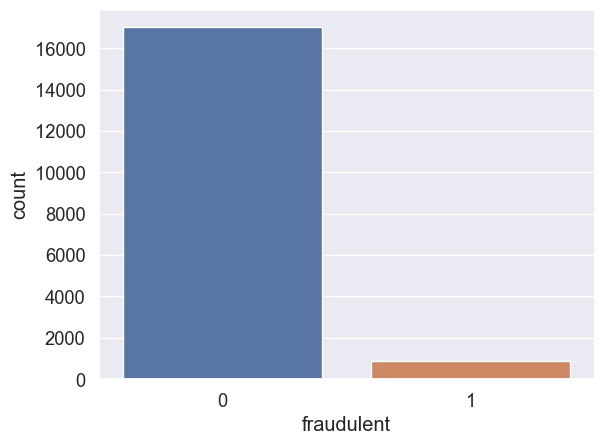

In [81]:
print("Total:",df.shape[0])
print("Non Fraudulent:", (-df["fraudulent"]+1).sum())
print("Fraudulent:", df["fraudulent"].sum())
print("Fraudulent percent:", np.round(df["fraudulent"].mean()*100,2), "%")
sns.countplot(data=df, x="fraudulent");

### Viewing Missing Data

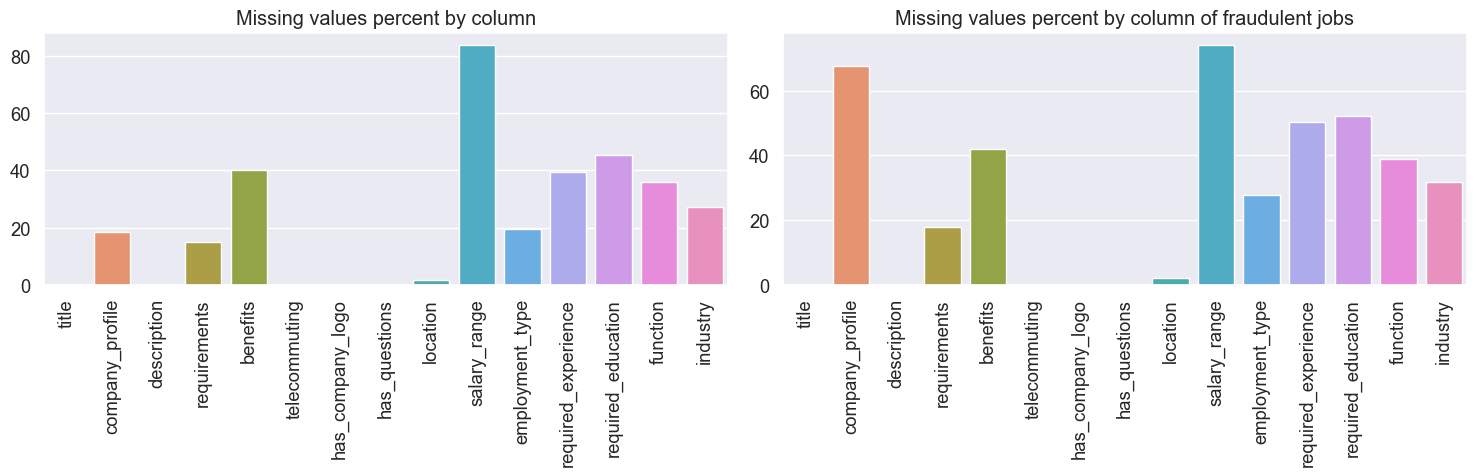

In [82]:
df_aux = df.drop(columns=TARGET_COL)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,5))
ax= sns.barplot(x=df_aux.columns, y=df_aux.isnull().sum()/df_aux.shape[0]*100, ax=ax0 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Missing values percent by column")

ax= sns.barplot(x=df_aux.columns, y=df_aux[df["fraudulent"]==1].isnull().sum()/df_aux[df["fraudulent"]==1].shape[0]*100, ax=ax1 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Missing values percent by column of fraudulent jobs");

plt.tight_layout()

### Observations

To take some observations a deeper analysis was made and can been seen [>here<](https://tiagopatriciosantos.github.io/myportfolio/images/datacamp.png)


**TEXT COLUMNS**
1. `title` - no missing data and looks good
2. `company_profile` - 18.5% percent of missing data in all dataset, when filtering only the fraudulent jobs this goes to near 70%, we can make the hypothesis that a job with no company profile have more chance of being fraudulent
3. `description` - observations with the value "#NAME?" will be replaced with empty string
4. `requirements` - observations with no meaningful text,['#NAME?', '.', '---', 'TBD', 'Test', '16-21', 'x', 'None'] will be replaced by empty string
5. Strings will be stripped and any missing data will be replaced by an empty string
6. text columns contains text likes this #URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd#, with the possible values being [URL_, PHONE_, EMAIL_] and encrypted text, this should be replaced by empty string, this text does not seems useful
7. Text contain unicode chars, convert text to ascii
8. Text contains words that are not separated, ex: pressureExcellent, when a lower capital letter is followed by capitalized letter then will be inserted one whitespace between them

**NUMERIC COLUMNS**
1. `telecommuting` - no missing data, value is either `0` or `1`
2. `has_company_logo` - no missing data, value is either `0` or `1`
3. `has_questions` - no missing data, value is either `0` or `1`

**CATEGORY COLUMNS**
1. `location` - 2% missing data, comma separated values, first value is country code, second is state/city code, more values after the second comma are detailed descriptions of state/city/location, we will keep the country code and state/city code in separate columns and drop this column
2. `employment_type` - 19.4 % missing data, 5 types ['Full-time', 'Contract', 'Part-time', 'Temporary', 'Other']
3. `required_experience` - almost 40% missing data, 7 types ['Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive']
4. `required_education` - 45.3% missing data, 13 types ["Bachelor's Degree", 'High School or equivalent', 'Unspecified', "Master's Degree", 'Associate Degree', 'Certification', 'Some College Coursework Completed', 'Professional', 'Vocational', 'Some High School Coursework', 'Doctorate', 'Vocational - HS Diploma', 'Vocational - Degree']
5. `function` - 36.1% missing data, 37 different types, "Information Technology" the most represented and "Science" the least one
6. `industry` - 27.4% missing data, 131 types "Information Technology and Services", "Computer Software" and "Internet" in the top 3 common
7. `salary_range` - more than 80% missing data, from the available data we can see that some data does not corresponds to a correct range for example `60-90` and `8-Sep` values, with so much missing data and with incorrect data we will drop this column. As suggestion is a necessary to review the way data is storage in this column.
8. Any missing data will be replaced by the word "MISSING"


### Cleaning data


#### TEXT COLUMNS

In [83]:
import re

def split_word(matchobj):
    """
    This function takes a match object and returns a string with a space
    inserted between the first and second characters of the matched string.
    
    :param matchobj: A match object.
    :return: A string with a space inserted between the first and second
             characters of the matched string
    """
    return  matchobj.group(0)[0] + " " +matchobj.group(0)[1]



df[TEXT_COLS] = df[TEXT_COLS].fillna("")

for col in TEXT_COLS:    
    #encode/decode with the 'ignore' option, it will remove non-ascii characters:
    df[col] = df[col].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'replace').decode())    
    # strip text
    df[col] = df[col].str.strip()
    #when a lower capital letter is followed by capitalized letter then will be inserted one whitespace between them
    df[col] = df[col].apply(lambda val: re.sub(r'([a-z][A-Z])', split_word, val))

In [84]:
# cleaning description
filter = df["description"].isin(['#NAME?'])
df.loc[filter, "description"] = ""

# cleaning requirements
filter = df["requirements"].str.strip().isin(['#NAME?', '.', '---', 'TBD', 'Test', '16-21', 'x', 'None'])
df.loc[filter, "requirements"] = ""

# replace encoded strings 
df[TEXT_COLS] = df[TEXT_COLS].replace(r"(#(EMAIL_|PHONE_|URL_)([^#])*#)|((EMAIL_|PHONE_|URL_)([^#])*##)", " " , regex=True)

#replace underscore with whitespace
for col in TEXT_COLS:  
    df[col] = df[col].str.replace("_"," ")


#### CATEGORY COLUMNS

In [85]:
df[CAT_COLS] = df[CAT_COLS].fillna("MISSING")

### Feature engineering

#### `location`

Split text by comma and keep only the 2 first values that represents the country code and city/state

In [86]:
df[["country", "state"]]=df["location"].str.split(",", expand=True, n=2)[[0,1]]
df[["country", "state"]]

df["country"] = df["country"].str.strip().replace("", "MISSING")
df["state"] = df["state"].str.strip().fillna("MISSING").replace("", "MISSING")


#### text columns to length columns

In [87]:
LEN_COLS = []
for col in TEXT_COLS:
    new_col = col+"_len"
    df[new_col] = df[col].str.len()
    LEN_COLS.append(new_col)
    NUM_COLS.append(new_col)


#### Columns choose

In [88]:
CAT_COLS.remove("location")
CAT_COLS = CAT_COLS + ["country","state"]

COLUMNS= TEXT_COLS + NUM_COLS + CAT_COLS + TARGET_COL
df = df[COLUMNS]
df.columns

Index(['title', 'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'title_len',
       'company_profile_len', 'description_len', 'requirements_len',
       'benefits_len', 'salary_range', 'employment_type',
       'required_experience', 'required_education', 'function', 'industry',
       'country', 'state', 'fraudulent'],
      dtype='object')

### Country and State
Most of the job posts are from the United States (US). Malaysia(MY) and Bahrain (BH) have the highest rate of fraudulent job posts, with more than 50% chance of a job post being fraudulent.

country
US          6.85
AU         18.69
GB          0.96
MISSING     5.49
MY         57.14
CA          2.63
QA         28.57
BH         55.56
IN          1.45
PL          3.95
Name: fraudulent, dtype: float64


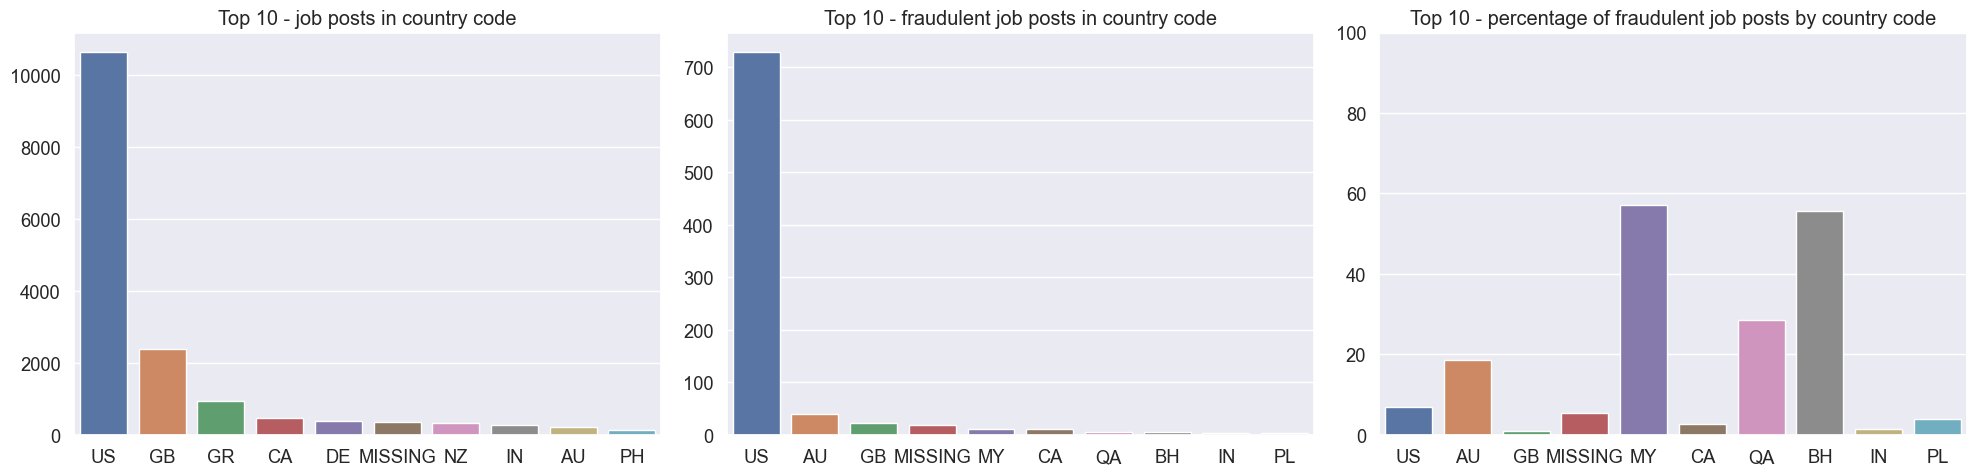

In [89]:
from pandas.api.types import CategoricalDtype

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(20,5) )



df_ana = df[["country","state", "fraudulent"]].copy()


countries_top10 = df_ana["country"].value_counts().head(10)
countries_top10_fraudulent = df_ana[df_ana["fraudulent"]==1]["country"].value_counts().head(10)
#to set order by when calculating percentage for each country
cat_country_order = CategoricalDtype( df_ana[df_ana["fraudulent"]==1]["country"].value_counts().index, ordered=True)
df_ana["country"] = df_ana["country"].astype(cat_country_order)


countries_top10_fraudulent_perc = df_ana.sort_values("country").groupby("country")["fraudulent"].mean().head(10)*100

print(countries_top10_fraudulent_perc.round(2))

sns.barplot(x=countries_top10.index, y=countries_top10.values  , ax = ax0).set(title="Top 10 - job posts in country code")
sns.barplot(x=countries_top10_fraudulent.index, y=countries_top10_fraudulent.values  , ax = ax1).set(title="Top 10 - fraudulent job posts in country code")
sns.barplot(x=countries_top10_fraudulent_perc.index.to_list(), y=countries_top10_fraudulent_perc.values  , ax = ax2).set(title="Top 10 - percentage of fraudulent job posts by country code", ylim=(0,100))
plt.tight_layout()

Looking into only US job post, California (CA) have the most quantity of job posts. Maryland (MD) have the highest rate of fake job posts.

state
TX         15.59
CA          6.97
NY          5.40
MISSING     7.53
MD         32.71
FL          7.23
GA          8.40
IL          4.25
OH          4.84
NC          7.56
Name: fraudulent, dtype: float64


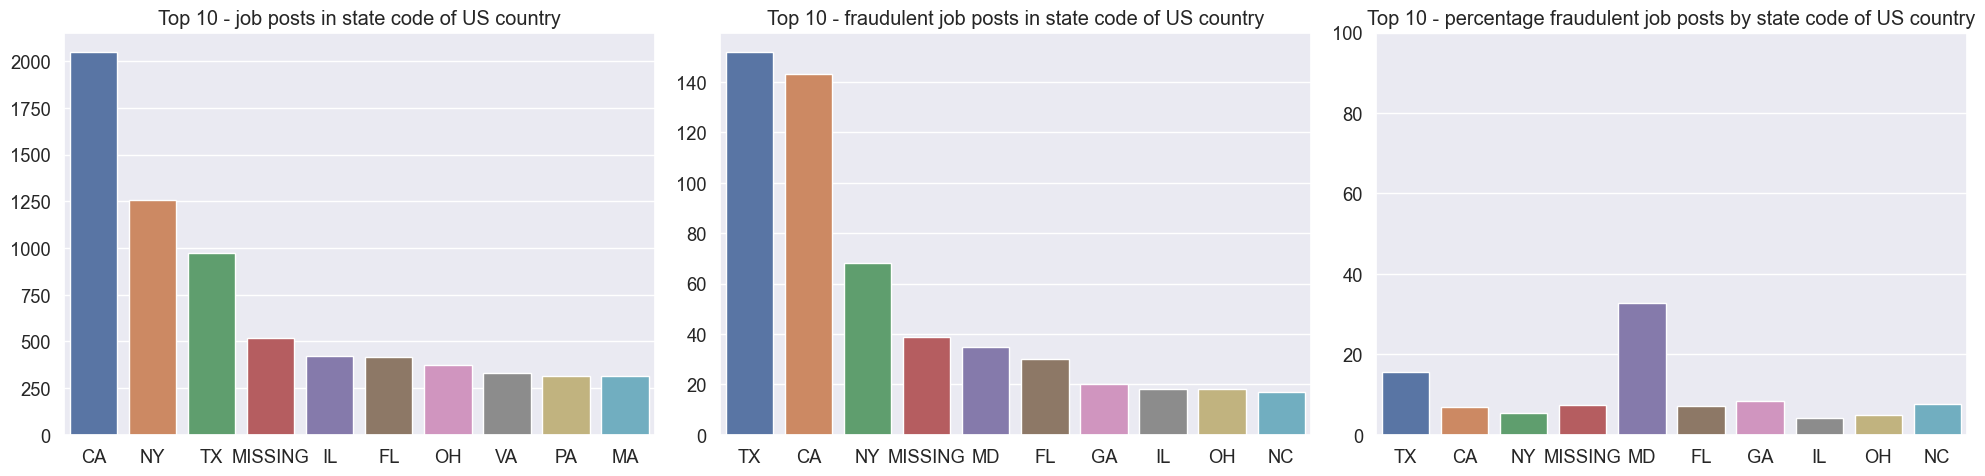

In [90]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(20,5))
df_country_us = df[df["country"]=="US"]


us_states_top10 = df_country_us["state"].value_counts().head(10)
us_states_top10_fraudulent = df_country_us[df_country_us["fraudulent"]==1]["state"].value_counts().head(10)
#to set order by when calculating percentage for each country
cat_state_order = CategoricalDtype( df_country_us[df_country_us["fraudulent"]==1]["state"].value_counts().index, ordered=True)
df_country_us["state"] = df_country_us["state"].astype(cat_state_order)
us_states_top10_fraudulent_perc = df_country_us.sort_values("state").groupby("state")["fraudulent"].mean().head(10)*100

print(us_states_top10_fraudulent_perc.round(2))

sns.barplot(x=us_states_top10.index, y=us_states_top10.values  , ax = ax0).set(title="Top 10 - job posts in state code of US country")
sns.barplot(x=us_states_top10_fraudulent.index, y=us_states_top10_fraudulent.values  , ax = ax1).set(title="Top 10 - fraudulent job posts in state code of US country")
sns.barplot(x=us_states_top10_fraudulent_perc.index.to_list(), y=us_states_top10_fraudulent_perc.values  , ax = ax2).set(title="Top 10 - percentage fraudulent job posts by state code of US country", ylim=(0,100))
plt.tight_layout()

### Numeric columns

Starting with a simple pandas describe for numeric columns:


In [91]:
df.describe()

telecommuting  has_company_logo  ...  benefits_len    fraudulent
count   17880.000000      17880.000000  ...  17880.000000  17880.000000
mean        0.042897          0.795302  ...    204.940045      0.048434
std         0.202631          0.403492  ...    329.356012      0.214688
min         0.000000          0.000000  ...      0.000000      0.000000
25%         0.000000          1.000000  ...      0.000000      0.000000
50%         0.000000          1.000000  ...     44.000000      0.000000
75%         0.000000          1.000000  ...    290.250000      0.000000
max         1.000000          1.000000  ...   4460.000000      1.000000

[8 rows x 9 columns]

Lets check numeric columns to see how they impact on job post being fraudulent.

using this symbols:
- P(T) - probability of Telecommuting 
- P(L) - probability of has_company_logo
- P(Q) - probability of has_questions
- P(F) - probability of fraudulent

We get this probabilities:
- $P(F \mid T)$ = 0.083442 $P(F \mid \overline{T})$ = 0.046865
- $P(F \mid L)$ = 0.019902 $P(F \mid \overline{L})$ = 0.15929
- $P(F \mid Q)$ = 0.028435 $P(F \mid \overline{Q})$ = 0.067782

Observations:
- Posts that have telecommuting (remote job), have a probability almost 2x greater to be fraudulent than not telecommuting.
- Not having the company logo have almost 7x the probability of being fraudulent than having logo.
- If screening questions are present, has_questions is true, the job post have almost 1/3 the probability to be fraudulent than not having screening questions.




telecommuting         0         1       All
fraudulent                                 
0              0.953135  0.916558  0.951566
1              0.046865  0.083442  0.048434
has_company_logo        0         1       All
fraudulent                                   
0                 0.84071  0.980098  0.951566
1                 0.15929  0.019902  0.048434
has_questions         0         1       All
fraudulent                                 
0              0.932218  0.971565  0.951566
1              0.067782  0.028435  0.048434


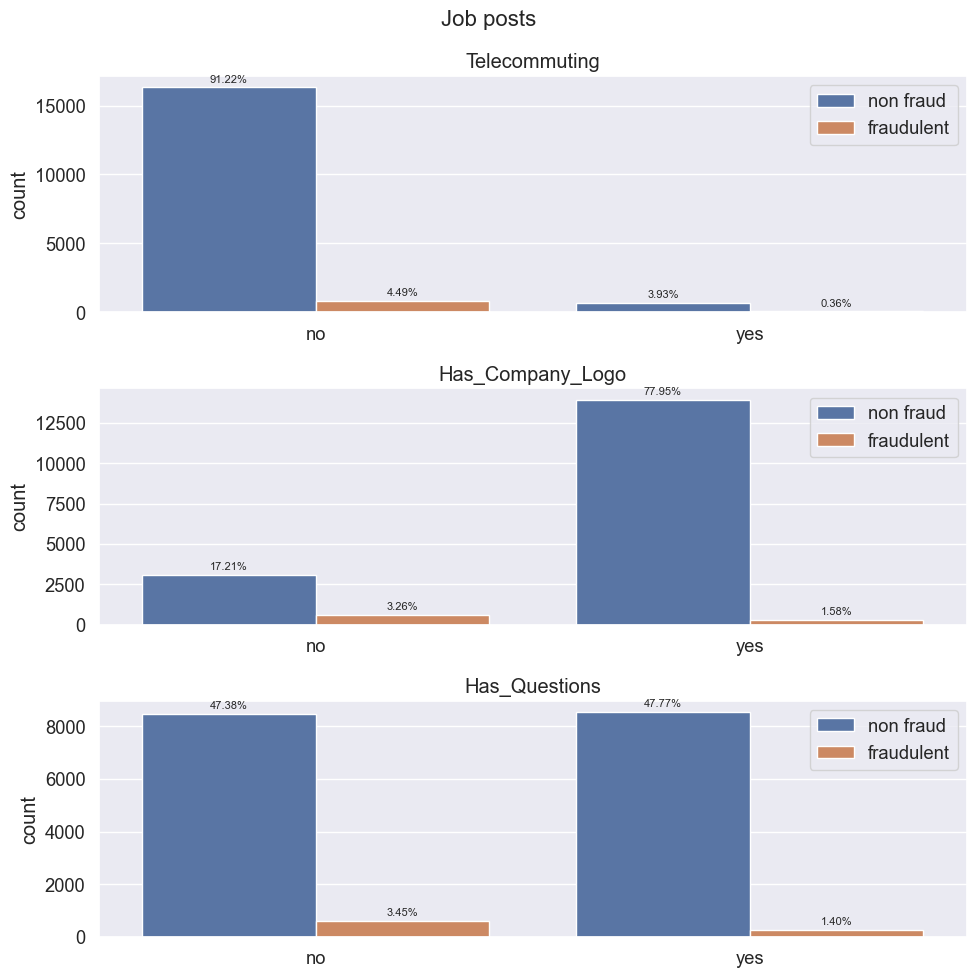

In [92]:
cols_inspect = ['telecommuting', 'has_company_logo', 'has_questions']

fig, axs = plt.subplots(nrows=len(cols_inspect),figsize=(10,10))
fig.suptitle('Job posts', fontsize=16)

def annotate_percent(ax, n):
    for a in ax.patches:
        val = np.round(a.get_height()/n*100,decimals=2)
        ax.annotate('{:.2f}%'.format(val) ,
            (a.get_x()+a.get_width()/2, a.get_height()),
            ha='center',
            va='center',
            xytext=(0, 6),
            textcoords='offset points',
            fontsize = 8,
          )

for i, col in enumerate(cols_inspect):         
    ax = axs[i]       
    # print("col:",df.groupby(col)["fraudulent"].mean())
    sns.countplot(data=df, x = col, hue="fraudulent", ax=ax).set(title=str.title(col))      
    annotate_percent(ax, df.shape[0])    
    ax.legend(['non fraud', 'fraudulent'])
    ax.set_xticks(ax.get_xticks(),["no", "yes"])
    ax.set_xlabel("")
    # creates a crosstab with the conditional probabilities
    print(pd.crosstab( df["fraudulent"],df[col], normalize='columns', margins=True))
    
plt.tight_layout()


Inspecting the kernel density of title, description and requirements separated by fraudulent and non fraudulent we can observe that longer titles tends to be fraudulent, smaller descriptions and requirements tend to be fraudulent job posts.

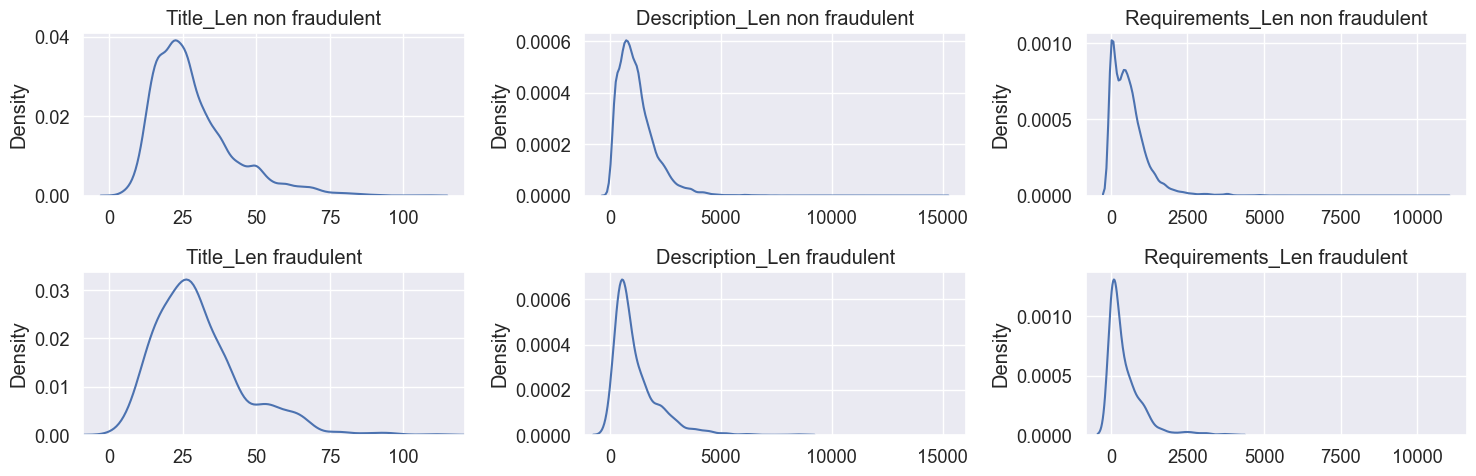

In [93]:
cols_inspect = ['title_len', 'description_len', 'requirements_len']

fig , axs = plt.subplots(nrows=2, ncols=len(cols_inspect), figsize=(15,5))

for i, col in enumerate(cols_inspect):
    ax = axs[0][i]
    
    sns.kdeplot(x=df[df["fraudulent"]==0][col], ax =ax)
    ticks = ax.get_xticks()
    xlim = ax.get_xlim()
    ax.set(title=str.title(col)+" non fraudulent" )
    ax.set_xlabel("")
    
    ax = axs[1][i]
    
    sns.kdeplot( x=df[df["fraudulent"]==1][col], ax =ax)
    ax.set_xticks(ticks)
    ax.set_xlim(xlim)
    ax.set(title=str.title(col)+" fraudulent" )
    ax.set_xlabel("")
plt.tight_layout()

## Processing the data

We will split data into training and test sets

In [94]:
train_df, test_df = train_test_split(df, stratify=df["fraudulent"], random_state = RANDOM_SEED) #using stratify because the imbalance of the target feature

In [95]:
# checking fraudulent percent in train_df
print("Fraudulent percent:", np.round(train_df["fraudulent"].mean()*100,2), "%")

Fraudulent percent: 4.85 %


Here, we try to scale and transform the len features to make them smoother, less skewed, and more appropriate for modeling.

`PowerTransformer` attempts to make the data more like a normal distribution, which should soften the impact of extreme outliers and make the distributions smoother.

`MinMaxScaler` is used as a first step to make sure the numbers are in a reasonable range, as `PowerTransformer` can fail on very large numbers.

In [96]:
pipeline = make_pipeline(MinMaxScaler(), PowerTransformer())

train_df_norm = pd.DataFrame(pipeline.fit_transform(train_df[LEN_COLS]), columns=LEN_COLS)
train_df_norm = train_df_norm.combine_first(train_df.reset_index()) # Add the other columns back

test_df_norm = pd.DataFrame(pipeline.fit_transform(test_df[LEN_COLS]), columns=LEN_COLS)
test_df_norm = test_df_norm.combine_first(test_df.reset_index()) # Add the other columns back


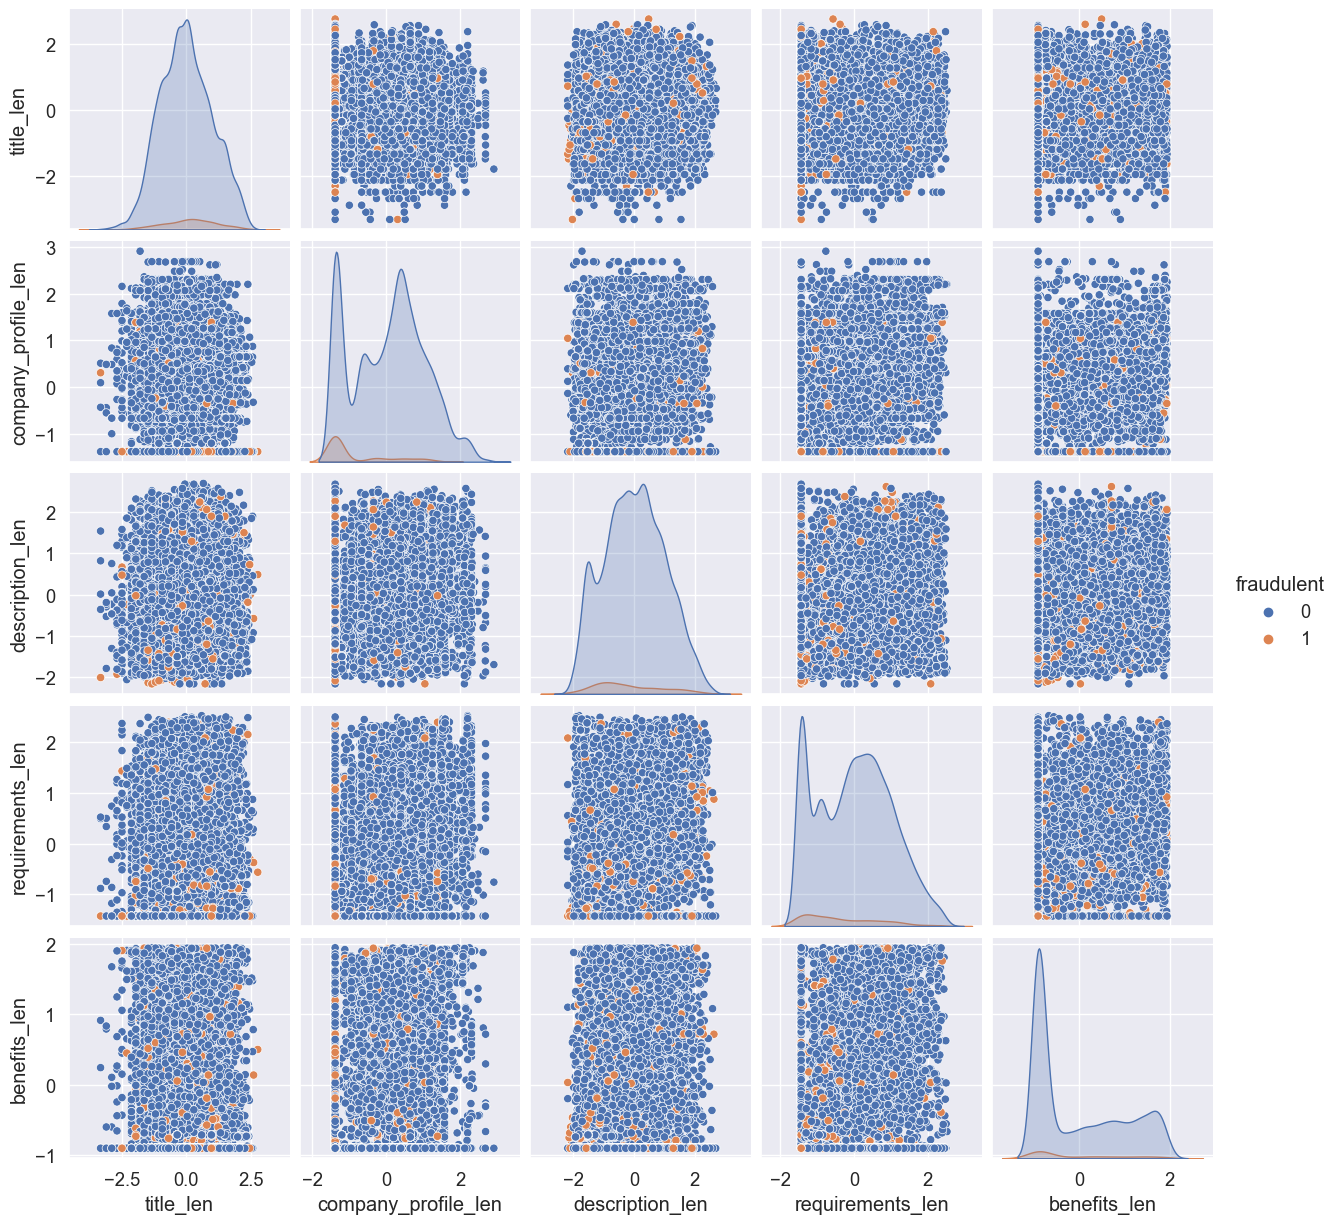

In [97]:
sns.pairplot(train_df_norm[LEN_COLS+TARGET_COL], hue="fraudulent") 

## Model training

For the time being, we'll only use the numeric columns for this model. The textual columns require specialized preprocessing before they can be used as input to a model.


In [98]:
X_train = train_df_norm[NUM_COLS]
y_train = train_df_norm[TARGET_COL]

X_test = test_df_norm[NUM_COLS]
y_test = test_df_norm[TARGET_COL]

### Functions

In [99]:
from time import time
from mpl_toolkits import axes_grid1


def f1_recall_precision_threshold(estimator, X, y_true, threshold=0.5):
    """
    This function takes a model, X and y_true as input and returns the predicitons and the f1, precision, recall scores
    
    Parameters
    ----------
    estimator : sklearn model
        The model to be used for prediction.
    X : numpy array
        The input data.
    y_true : numpy array
        The true labels.
    threshold : float, default=0.5
        Value of the threshold between 0 and 1    
    Returns
    -------
    y_pred : numpy array
        The predicted value for positive class.
    y_pred_proba : numpy array
        The predicted probabilities for positive class.
    f1score : float
        The f1score.
    recall : float
        The recall score.
    precision : float
        The precision score.
    """
    y_pred_proba = estimator.predict_proba(X)[:,1] # predictions probability for positive class
    y_pred = y_pred_proba >= threshold
    
    f1score = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    
    return y_pred, y_pred_proba, f1score, recall, precision
    

def add_colorbar(ax, im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def optimal_values(estimator, X_train, y_train, X_test, y_test, plot_charts=False, threshold_index=None, threshold_value=None):
    """
    This function takes a model, X and y_true as input and returns the optimal threshold, f1score, precision and recall.
    
    If threshold_index is passed it will use the index to return preditions and metrics based in that index.
    
    Parameters
    ----------
    estimator : sklearn model
        The model to be used for prediction.
    X_train : numpy array
        The train data.
    y_train : numpy array
        The train labels.
    X_test : numpy array
        The test data.
    y_test : numpy array
        The test labels.
    plot_charts : bool, optional
        Whether to plot the optimal confusion matrix and precision vs recall chart. The default is False.
    threshold_index : int, default=None
        Index of the threshold list, if set then threshold_value will be ignored
    threshold_value : float, default=None
        Value of the threshold to consider
    
    Returns
    -------
    values : dict
        {"params": {"threshold": threshold_opt},
              "train": {"f1": f1score_opt,
                        "precision":precision_opt,
                        "recall": recall_opt
                        },
              "test": {"f1": test_f1score,
                       "precision": test_precision,
                       "recall": test_recall
                      }
         }   
    """
    
    # predictions probability for positive class for train set
    y_pred_proba = estimator.predict_proba(X_train)[:,1] 
    
    # Compute precision-recall pairs for different probability thresholds.
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_pred_proba)
    
#      # precision, recall manual calculations
#     y = np.array(y_true).reshape((-1,1))
#     pred = (y_pred_proba>= thresholds.reshape((-1,1))).T
#     TP = np.sum(np.logical_and(y , pred ), axis=0)
#     FN = np.sum(np.logical_and(y , np.logical_not(pred)), axis=0)
#     FP = np.sum( np.logical_and(np.logical_not(y) , pred), axis=0)
#     recall = np.append((TP /(TP+FN)), 0)
#     precision = np.append((TP /(TP+FP)), 1)
#     print("TP",TP, "FN",FN, "FP", FP,"recall", recall,"precision",precision)

    # calculates f1 scores
    # if threshold_index defined then will use the index to identify the threshold, f1, precision and recall
    # else uses the index of the max f1 score to identify the index to get opt threshold, f1, precision and recall
    f1score = 2*(precision*recall)/(precision+recall)
    if threshold_index:
        index=threshold_index
        threshold_opt = thresholds[index]
    elif threshold_value:
        thresholds_aux = np.where(thresholds <= threshold_value, thresholds, 0)
        index = np.nanargmax(thresholds_aux)    
        threshold_opt = threshold_value
    else:        
        index = np.nanargmax(f1score)
        threshold_opt = thresholds[index]
        
    f1score_opt = f1score[index] if not np.isnan(f1score[index]) else 0.0
    precision_opt = precision[index]
    recall_opt = recall[index]
        
    # using the opt threshold based on the f1 score calculates the preditions, f1, precision and recall for test set
    y_test_pred, y_test_pred_proba, test_f1score, test_recall, test_precision = f1_recall_precision_threshold(estimator, X_test, y_test, threshold_opt)
    
    if plot_charts:

        gs_kw = dict(width_ratios=[1, 3, 1, 1])
        fig, axd  = plt.subplot_mosaic([['text', 'precision_recall', 'cm_train','cm_test']],
                                          gridspec_kw=gs_kw, figsize=(16, 5),
                                          layout="tight")
        ax0= axd["text"]
        ax1= axd["precision_recall"]
        ax2= axd["cm_train"]
        ax3= axd["cm_test"]
        
        # Set both x-axis limits to [0, 10] and y-axis limits to [0, 20] instead of default [0, 1]
        y_top = 14
        ax0.axis([0, 10, 0, y_top])       
        model_name = estimator.__class__.__name__
        # ax0.set_title("Model : " + model_name, loc='left')            
                   
        ax0.text(0,y_top -1 , "Model : " + model_name) 
        ax0.text(0,y_top -3 , f"threshold ≈ {np.round(threshold_opt,4)}" ) 
        ax0.text(0,y_top -5 , f"Train:" ) 
        ax0.text(1,y_top -6 , f"precision ≈ {np.round(precision_opt,4)}" ) 
        ax0.text(1,y_top -7 , f"recall ≈ {np.round(recall_opt,4)}" )
        ax0.text(1,y_top -8 , f"f1 ≈ {np.round(f1score_opt,4)}" )
        ax0.text(0,y_top -10 , f"Test:" ) 
        ax0.text(1,y_top -11 , f"precision ≈ {np.round(test_precision,4)}" ) 
        ax0.text(1,y_top -12 , f"recall ≈ {np.round(test_recall,4)}" )
        ax0.text(1,y_top -13 , f"f1 ≈ {np.round(test_f1score,4)}" )
        ax0.set_xticks([]) 
        ax0.set_yticks([])
        ax0.grid(False)
        ax0.patch.set_alpha(0)        
        
        y_pred = y_pred_proba >= threshold_opt                
        cm = metrics.ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax2, colorbar=False)   
        add_colorbar(ax2, cm.im_)
        ax2.set_title("Train confusion matrix")
        ax2.grid(False)
        
        y_pred = y_test_pred_proba >= threshold_opt
        cm=metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax3, colorbar=False)        
        add_colorbar(ax3, cm.im_)
        ax3.set_title("Test confusion matrix")
        ax3.grid(False)
        
        # plot line plots with train f1 scores, precision, recall and optimal values, 
        # annotates also some thresholds to easy identify other points of possible interest
        ax1.set_title("Train thresholds metrics evaluation (TH=threshold)")
        sns.lineplot(x=range(len(precision)), y=precision, label="Precision",color='b', ax=ax1)
        sns.lineplot(x=range(len(recall)), y=recall, label="Recall",color='orange', ax=ax1)
        sns.lineplot(x=range(len(f1score)), y=f1score, label="F1 score",color='g', ax=ax1)
        text_annot = f"TH {np.round(threshold_opt,3)}"
        ax1.annotate(text_annot, (index, 0), size=10)
        # text_annot = f"F1 {np.round(f1score_opt,2)}"
        # ax1.annotate(text_annot, (index, f1score_opt), size=10)
        xlim0, xlim1 = ax1.get_xlim()        
        ylim0, ylim1= ax1.get_ylim()
        x_point = index/xlim1
        # y_point = f1score_opt- ylim0/2
        ax1.axhline(y=f1score_opt, xmax=x_point,linewidth=1, color='r', alpha=0.7,ls="--")
        ax1.axvline(x=index, linewidth=1, color='r', alpha=0.7,ls="--")
        
        blue_line = mlines.Line2D([], [], color='blue', marker='_', label='Precision')
        orange_line = mlines.Line2D([], [], color='orange', marker='_', label='Recall')
        green_line = mlines.Line2D([], [], color='green', marker='_', label='F1 score')
        red_line = mlines.Line2D([], [],linewidth=1, color='red', linestyle='--', alpha=0.7, label='F1 opt')
        ax1.legend(handles=[blue_line,orange_line, green_line,red_line])

        ax1.set_xlabel("Threshold index")
        ax1.set_ylabel("Score")
        minor_tick = np.arange(0, len(f1score), 100)
        ax1.set_xticks(minor_tick, minor=True)
        ax1.grid(visible=True, which='major', axis="x")
        ax1.grid(visible=True, which='minor',axis="x", alpha=0.4)
        if not threshold_index:
            for i in np.linspace(0, index, 6, dtype=int)[1:-1]:
                recall_value = recall[i]
                threshold_value = thresholds[i]
                y_point = recall_value/ylim1
                ax1.axvline(x=i, ymax=y_point,linewidth=1, color='y', alpha=0.8,ls="--" )
                text_annot = f"TH {np.round(threshold_value,3)}"
                ax1.annotate(text_annot, (i, recall_value-0.05), size=10)        

    
    # dict to return values
    values = {"params": {"threshold": threshold_opt},
              "train": {"f1": f1score_opt,
                        "precision":precision_opt,
                        "recall": recall_opt
                        },
              "test": {"f1": test_f1score,
                       "precision": test_precision,
                       "recall": test_recall
                      }
             }
    
    return values


### Baseline - DummyClassifier

Now, we'll fit a DummyClassifier, this makes predictions that ignore the input features.

This classifier serves as a simple baseline to compare against other more complex classifiers.

In [100]:
clf_baseline = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
clf_baseline.fit(X_train, y_train)


DummyClassifier(random_state=42, strategy='most_frequent')

### Evaluation and Metric choose

Since we know that the classes are very imbalanced (only about 4.84% of the questions labeled as fraudulent), as we can see using the dummy model that have 50% of probability of a guess to be right is giving a ~95% accuracy, we'll avoid using the accuracy metric. Instead, we'll take a look at the precision-recall curve, which can tell us more useful information.


In [101]:
y_pred = clf_baseline.predict(X_test)
print("Accuracy:",np.round( metrics.accuracy_score(y_test, y_pred),4), " = portion of non fraudulent job posts:", np.round(1-np.mean(y_test.values),4))

Accuracy: 0.9517  = portion of non fraudulent job posts: 0.9517



Having  the follow confusion matrix:

|               | Positive Prediction | Negative Prediction |
|---------------|-------------------- |---------------------|
|Positive Class | True Positive (TP)  | False Negative (FN) |
|Negative Class | False Positive (FP) | True Negative (TN)  |



One thing that we want to avoid is to get in-touch with people that posted a fake job post, as stated in the beginning of this notebook "they would prefer that your solution risks filtering out real posts if it decreases the number of fraudulent posts they apply to", so we need to maximize how well our model identifies fake job posts reducing the False Negatives predictions, to deal with that we will use the Recall metric. In other hand we don't want our model to have a bad quality predicting fake job posts, having to much not fraudulent job posts classified as fake, we will use the Precision metric to evaluate this.
- Recall = Sensitivity = TPR = $\frac{TP}{TP + FN}$
- Precision = $\frac{TP}{TP + FP}$

How to choose Precision and Recall?
Almost always, in practice, we have to choose between a high precision or a high recall. It’s usually impossible to have both. 
We can achieve either of the two by various means:
- Assigning a higher weighting to the examples of a specific class (the SVM algorithm accepts weightings of classes as input)
- Tuning hyperparameters to maximize precision or recall on the validation set.
- Varying the decision threshold for algorithms that return probabilities of classes; for instance, if we use logistic regression or decision tree, to increase recall (at the cost of a lower precision), we can decide that the prediction will be positive only if the probability returned by the model is higher than 0.2. We will use this approach.


Another metric we will use to evaluate how well the model does predictions it will be the F1-score. F1-score is the geometric average of precision and recall. F1-score relies between 0 and 1, with 1 being the best value.

By default, machine learning models use a threshold of 0.5. This means that if a prediction probability is equal to or higher than 0.5, it is classified as "1"; otherwise, it is classified as "0". In our case, we will consider a **threshold** of **4.85%**. This number represents the percentage of fraudulent job posts in the training dataset. We will compare this threshold with the optimal threshold obtained using the Precision-Recall curve. This will help us identify the threshold that produces the maximum F1-score.
Tuning or shifting the decision threshold in order to accommodate the broader requirements of the classification problem is generally referred to as "threshold-moving" "threshold-tuning" or simply "thresholding". 

- f1score = $ {2 \ast \frac{precision * recall}{precision + recall}} $


Great articles about classification metrics and threshold calculations:
- https://neptune.ai/blog/evaluation-metrics-binary-classification
- https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293



Predicting using the default threshold using the dummy model where every prediction is the most frequent class, in this case is the class "0", it predicts always class "0".
Changing the threshold to zero makes all predictions to became class "1". Well this is the dummy model, nothing more than dummy predictions.

The evaluation of metrics chosen are most understandable in models that learn something from the data. Next we will see the LogisticRegression model.

{'params': {'threshold': 0.5}, 'train': {'f1': 0.09246088193456614, 'precision': 0.048471290082028336, 'recall': 1.0}, 'test': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0}}


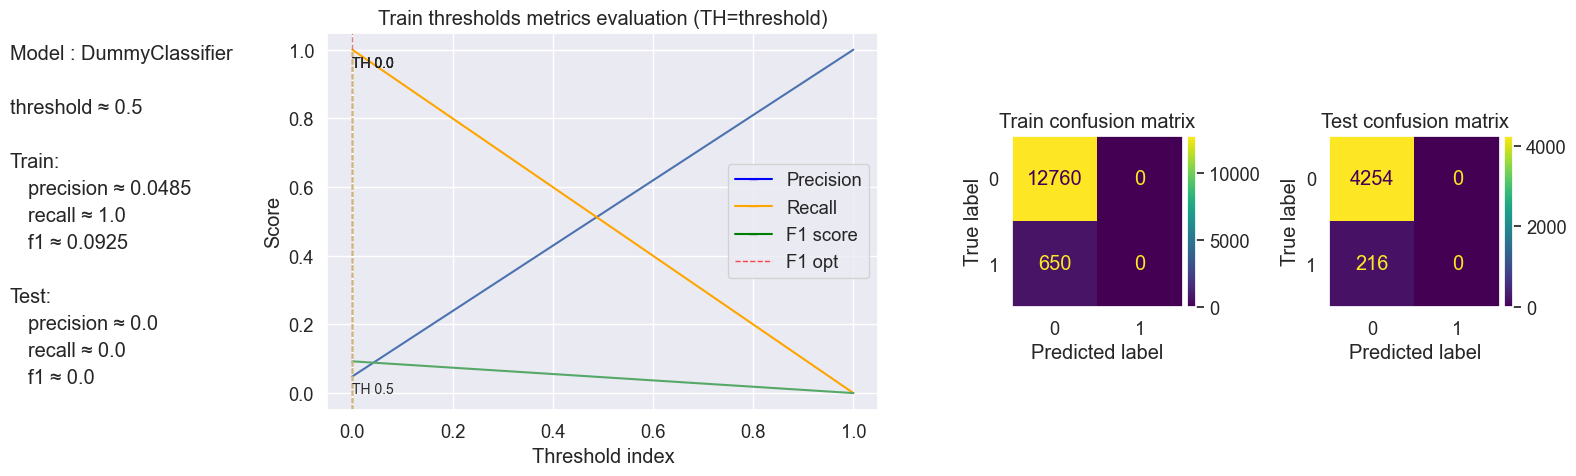

In [102]:
values = optimal_values(clf_baseline, X_train, y_train, X_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict = {"Baseline dummy": {"default": values}}
print(values)

{'params': {'threshold': 0.0}, 'train': {'f1': 0.09246088193456614, 'precision': 0.048471290082028336, 'recall': 1.0}, 'test': {'f1': 0.09218950064020486, 'precision': 0.04832214765100671, 'recall': 1.0}}


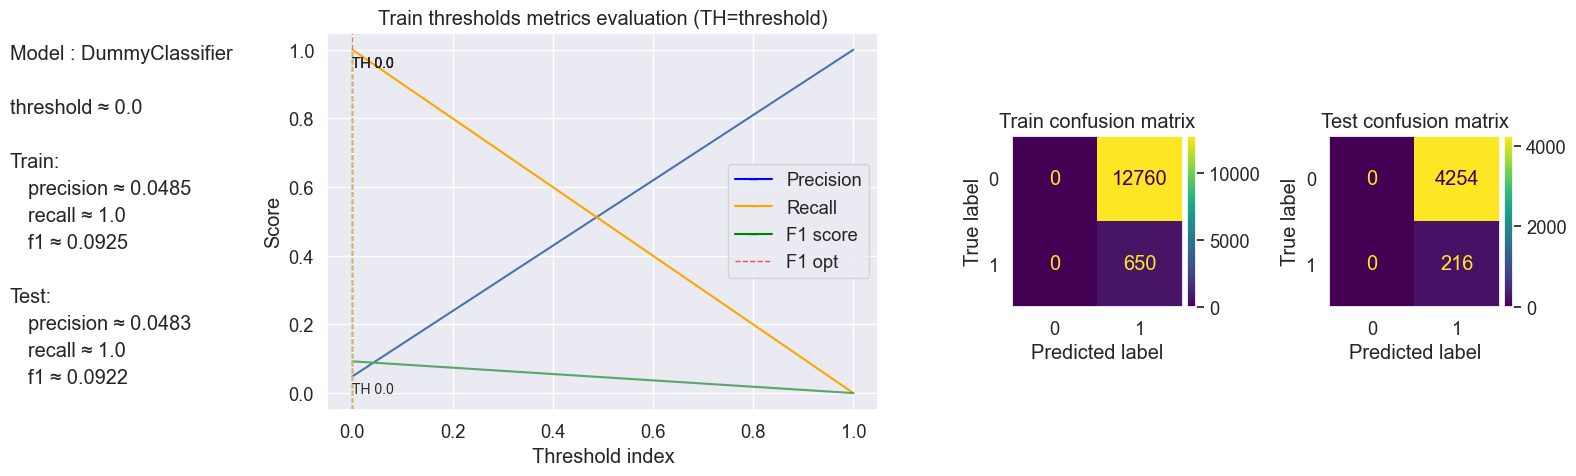

In [103]:
values = optimal_values(clf_baseline, X_train, y_train, X_test, y_test, plot_charts=True)
#storing this values to compare
compare_dict["Baseline dummy"]["f1_opt"]= values
print(values)

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.09246088193456614, 'precision': 0.048471290082028336, 'recall': 1.0}, 'test': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0}}


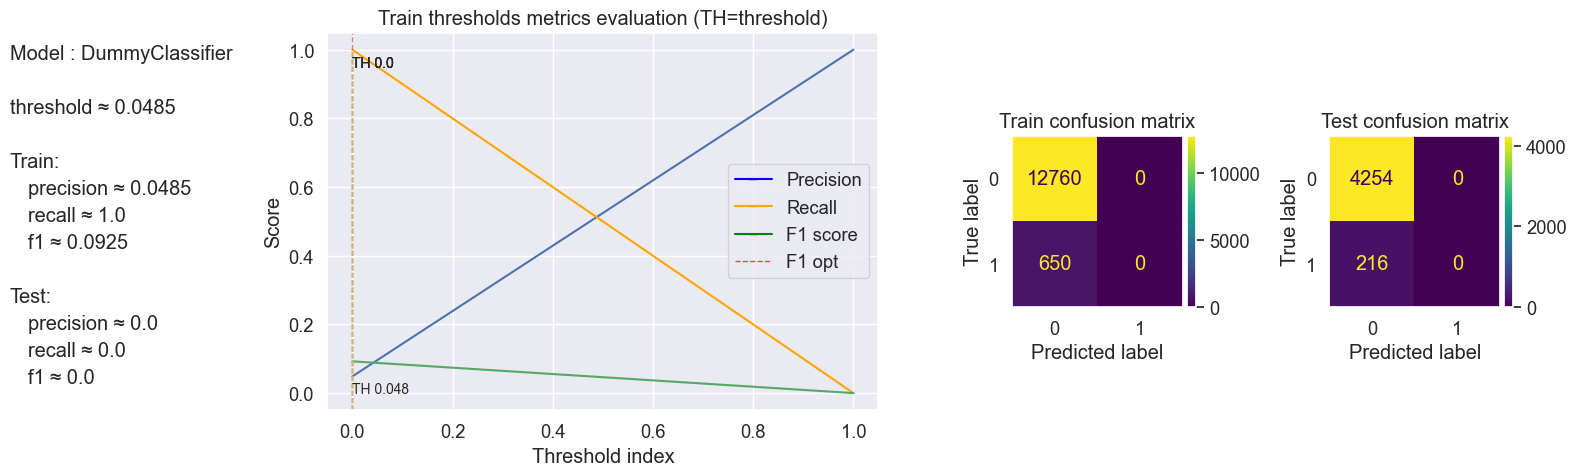

In [104]:
values = optimal_values(clf_baseline, X_train, y_train, X_test, y_test, plot_charts=True, threshold_value=0.0485)
#storing this values to compare
compare_dict["Baseline dummy"]["th_opt"]= values
print(values)

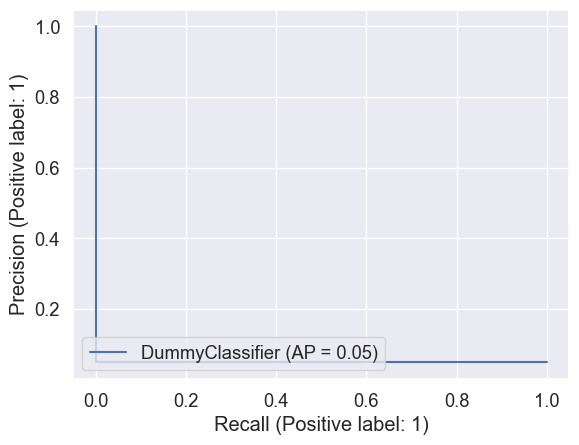

In [105]:
# Precision vs recall for each threshold
metrics.PrecisionRecallDisplay.from_estimator(clf_baseline, X_test, y_test)


### LogisticRegression

Now, we'll fit a basic Logistic Regression model to our data, to see that it manages to learn anything. We're not trying to optimize it yet, just see that it successfully learns something useful, and that our preparation of the data helped.

In [106]:
clf_logreg = LogisticRegression(random_state = RANDOM_SEED)
clf_logreg.fit(X_train, np.ravel(y_train))


LogisticRegression(random_state=42)

#### Evaluation numeric features model

{'params': {'threshold': 0.5}, 'train': {'f1': 0.0030627871362940277, 'precision': 0.3333333333333333, 'recall': 0.0015384615384615385}, 'test': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0}}


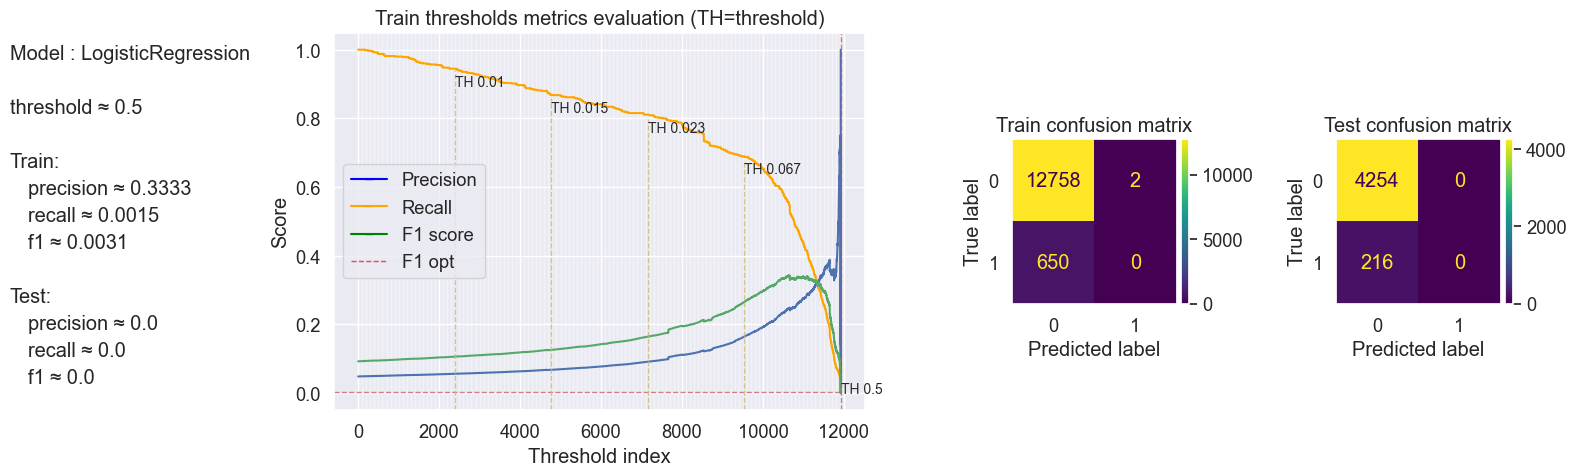

In [107]:
values = optimal_values(clf_logreg, X_train, y_train, X_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic numeric"]= {"default": values}
print(values)

It looks like the model learned almost nothing, lets calculate the threshold based on max f1 score and inspect again the confusion matrix.

Recall is still way to much low, only $\approx$33% of the true fraudulent job posts are predicted as fraudulent in our test, Precision is a little better but still to low and as consequence F1-score is also to low.

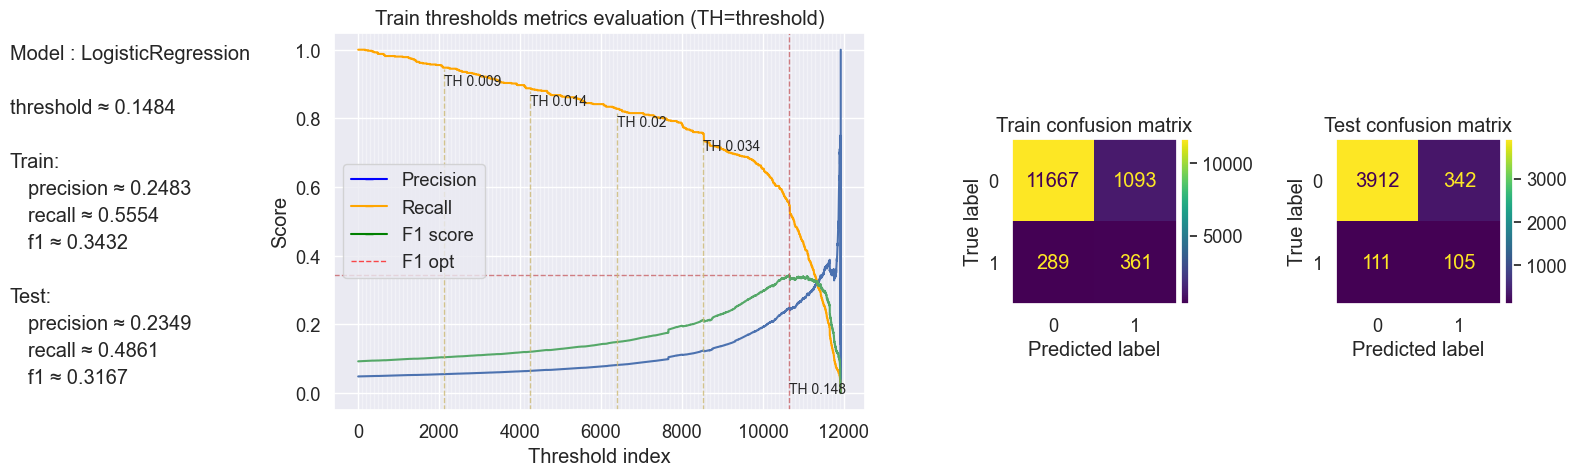

In [108]:
values = optimal_values(clf_logreg, X_train, y_train, X_test, y_test, plot_charts=True)

#storing this values to compare
compare_dict["Logistic numeric"]["f1_opt"]= values

But if we use the 0.0485 threshold we can see a drastic improvement in our recall, we almost doubled this metric in the train and test datasets, but we have a low precision score making the F1 score also too low  

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.24142515288487107, 'precision': 0.14593378334940535, 'recall': 0.6984615384615385}, 'test': {'f1': 0.22222222222222224, 'precision': 0.1349206349206349, 'recall': 0.6296296296296297}}


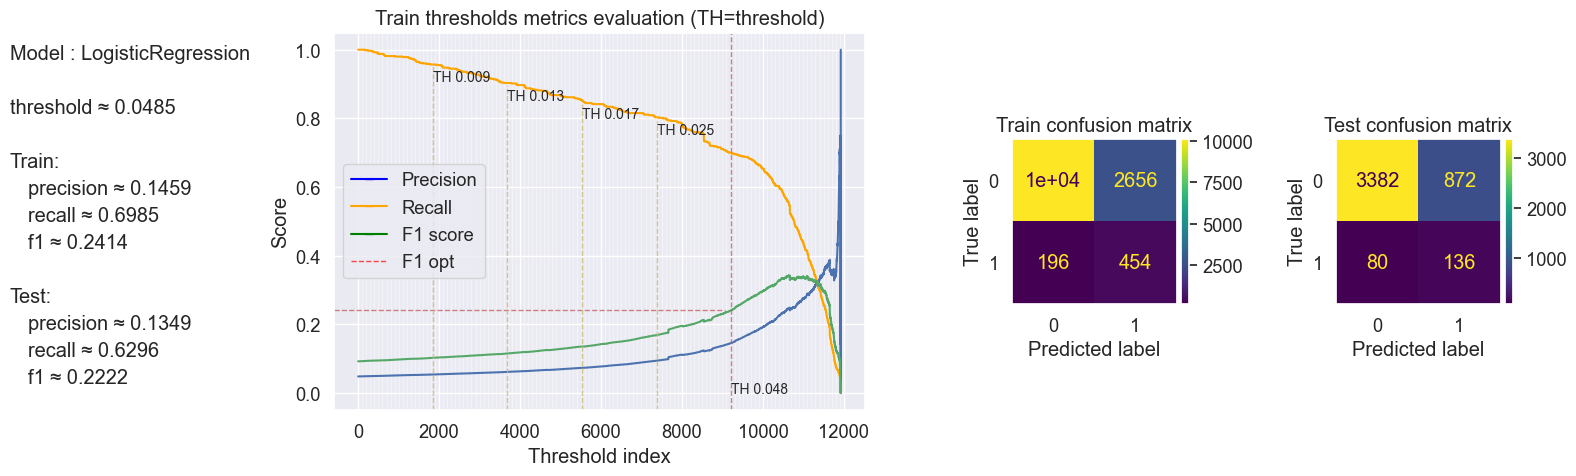

In [109]:
values = optimal_values(clf_logreg, X_train, y_train, X_test, y_test, plot_charts=True, threshold_value=0.0485)

#storing this values to compare
compare_dict["Logistic numeric"]["th_opt"]= values
print(values)

Text(0.6496296296296297, 0.1349206349206349, 'Threshold ≈ 0.0485\nf1-score ≈ 0.22')

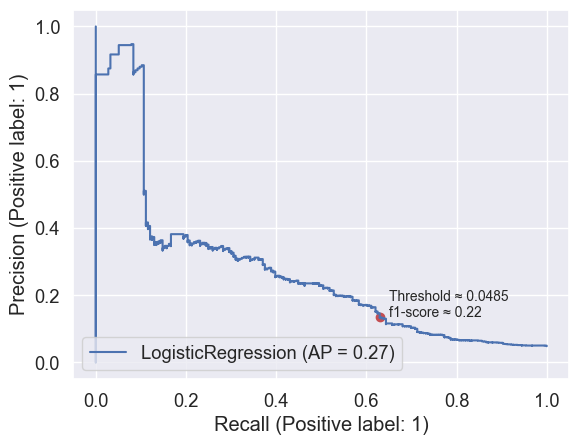

In [110]:
metrics.PrecisionRecallDisplay.from_estimator(clf_logreg , X_test, y_test) # AP = average precision
threshold_opt = values["params"]["threshold"]
recall = values["test"]["recall"]
f1score = values["test"]["f1"]
precision = values["test"]["precision"]
plt.scatter(recall, precision, color="r")
text_annot = f"Threshold ≈ {np.round(threshold_opt,4)}\nf1-score ≈ {np.round(f1score,2)}"
plt.annotate(text_annot, (recall+0.02, precision), size=10)

Using only the numeric features we can see that the Logistic Regression model achieves an average precision of 0.25, and we can see that he did really learn useful information from the data, but only when the threshold was moved.

We can also look at the learned feature importances to understand what our model is looking for:

<AxesSubplot:>

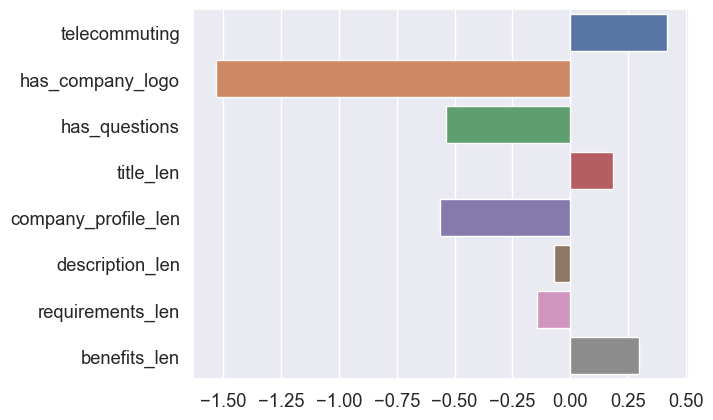

In [111]:
sns.barplot(y=NUM_COLS, x=clf_logreg.coef_[0])

Recall that this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. 
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

`has_company_logo` have the most importance in the model predicting the class `0` while `has_question` have some importance.

`telecommuting` have the most importance predicting the class `1`. 

`title_len` have positive importance, `description_len` and `requirements_len` have negative importance but almost no importance when predicting the class.

This is aligned with our EDA on numeric columns where we checked the conditional probability and the kernel density of text length.

#### NLP - Textual Features

So, at this point we have a sense for our data, have found a good way to scale and normalize our *numeric* features, and have trained a very basic classifier on it.

Introduction to NLP, Natural Language Processing is a branch of Artificial Intelligence that analyzes, processes, and efficiently retrieves information text data.

The next phase would be to see what happens when we take advantage of using techniques from NLP in our textual features  - `title`, `company_profile`, `description`, `requirements`. We'll use *only* the textual features to simplify things and isolate the effects.

To start simple, we'll unify only `title` and `description` into one big textual column. Latter we will try another approach unifying all textual columns.

In [112]:
train_text_col = train_df_norm["title"] +" "+ train_df_norm["description"] 
test_text_col = test_df_norm["title"] +" "+ test_df_norm["description"] 

To turn this text into numerical features that can be used as input to a ML model, we'll use [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with a sensible limit of vocabulary size (`max_features=25000`). It will split the text into tokens, and give each text in the data a numerical representation of the frequency of tokens in that text.

Note that special care is needed when handling [sparse matrices in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html), and the result returned from `TfidfVectorizer` is a sparse matrix. **If you ignore this special handling, expect to run into out-of-memory errors, unresponsiveness and crashes as the sparse matrix gets inflated.**

In [113]:
tfidf = TfidfVectorizer(max_features=25000)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())


**Interesting notes:**
* Since the English Longest word in a major dictionary is Pneumonoultramicroscopicsilicovolcanoconiosis (45 letters) ( Pneumoconiosis caused by inhalation of very fine silicate or quartz dust. ) and the second is Hippopotomonstrosesquippedaliophobia (36 letters) we will make a regex expression that will only consider alpha numeric words no longer than 35 letters. 
Source:https://irisreading.com/10-longest-words-in-the-english-language/
* We also will ignore words that start with a number


In [114]:
print("words with more than 36 letters:", [w for w in tfidf.get_feature_names_out() if len(w) >36][:10])

words with more than 36 letters: ['yijdnw4jujjilj17glxmbmfmqvbeix022dcqup8rsgcn4zyfax1c1nuxkpu1q66j']


In [115]:

PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN)
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()


In [116]:
print(train_tfidf_df.shape)
train_tfidf_df.sample(15, axis=1).head()

(13410, 25000)


njhmfa  rome  adm201  volunerable  ...  fwa  gene  prudently  wakes
0     0.0   0.0     0.0          0.0  ...  0.0   0.0        0.0    0.0
1     0.0   0.0     0.0          0.0  ...  0.0   0.0        0.0    0.0
2     0.0   0.0     0.0          0.0  ...  0.0   0.0        0.0    0.0
3     0.0   0.0     0.0          0.0  ...  0.0   0.0        0.0    0.0
4     0.0   0.0     0.0          0.0  ...  0.0   0.0        0.0    0.0

[5 rows x 15 columns]

In [117]:
clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, np.ravel(y_train))

LogisticRegression(random_state=42)

#### Evaluating the textual model

Below, we can see that the new text-based model performs way better!

This is not surprising, as most information will be contained in the text content of each post.

Without adjusting the threshold we get a great precision but a bad recall, F1-score gets near 0.41.


{'params': {'threshold': 0.5}, 'train': {'f1': 0.5, 'precision': 0.9954128440366973, 'recall': 0.33384615384615385}, 'test': {'f1': 0.41025641025641024, 'precision': 0.9824561403508771, 'recall': 0.25925925925925924}}


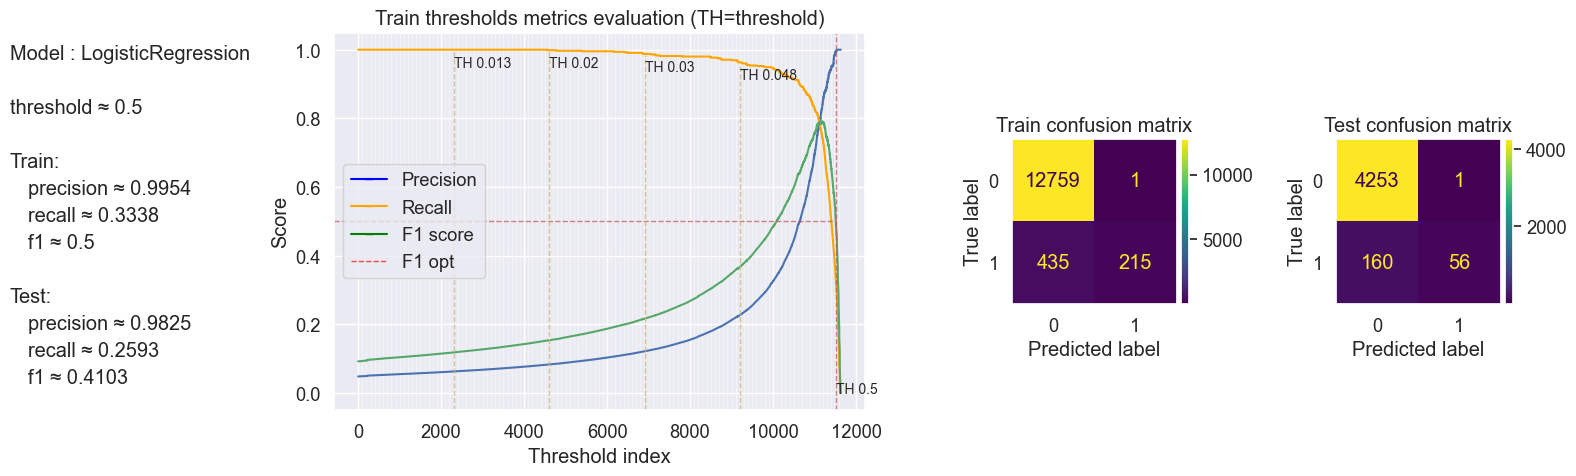

In [118]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic tfidf"]= {"default": values}
print(values)

Lets calculate the threshold based on max f1 score and inspect again the confusion matrix.

With a threshold of ≈0.156 we have a good Recall, $\approx$63% of the true fraudulent job posts are predicted as fraudulent in our test, Precision is high as consequence we have a good F1-score.

{'params': {'threshold': 0.15577321267865177}, 'train': {'f1': 0.7908082408874801, 'precision': 0.815359477124183, 'recall': 0.7676923076923077}, 'test': {'f1': 0.6901763224181361, 'precision': 0.7569060773480663, 'recall': 0.6342592592592593}}


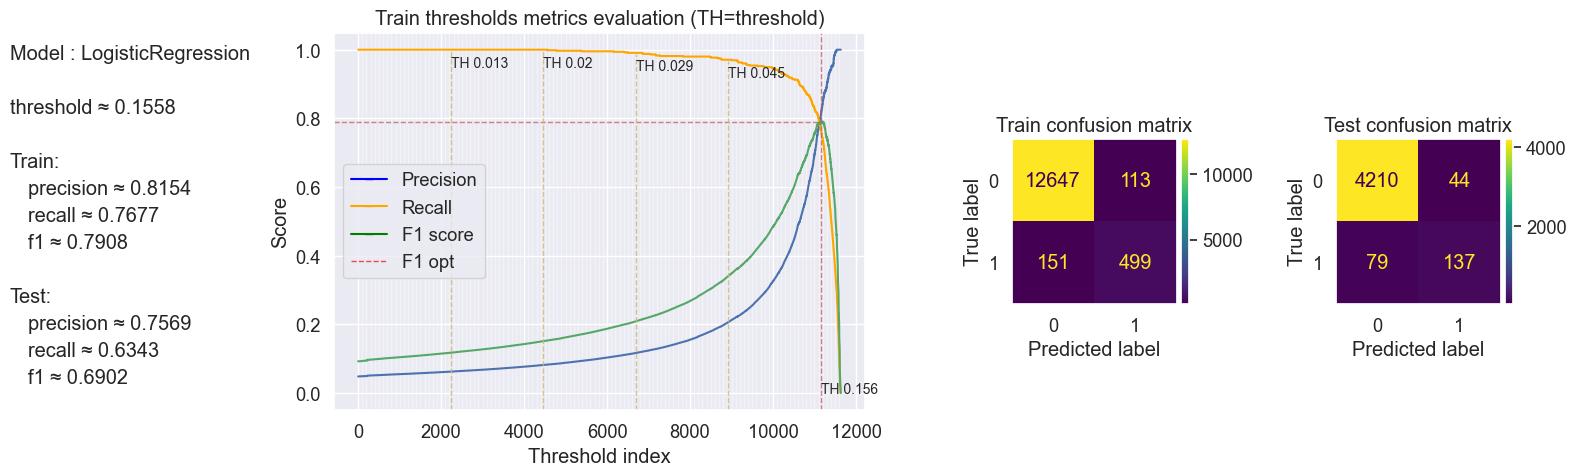

In [119]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True)
#storing this values to compare
compare_dict["Logistic tfidf"]["f1_opt"]= values
print(values)

Using the 0.0485 threshold we have great recall metric, ≈91% of the true fraudulent job posts are predicted as fraudulent in our test. Precision and F1 score are not so great.

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.3705238236164546, 'precision': 0.22938805423231953, 'recall': 0.963076923076923}, 'test': {'f1': 0.35304659498207885, 'precision': 0.21888888888888888, 'recall': 0.9120370370370371}}


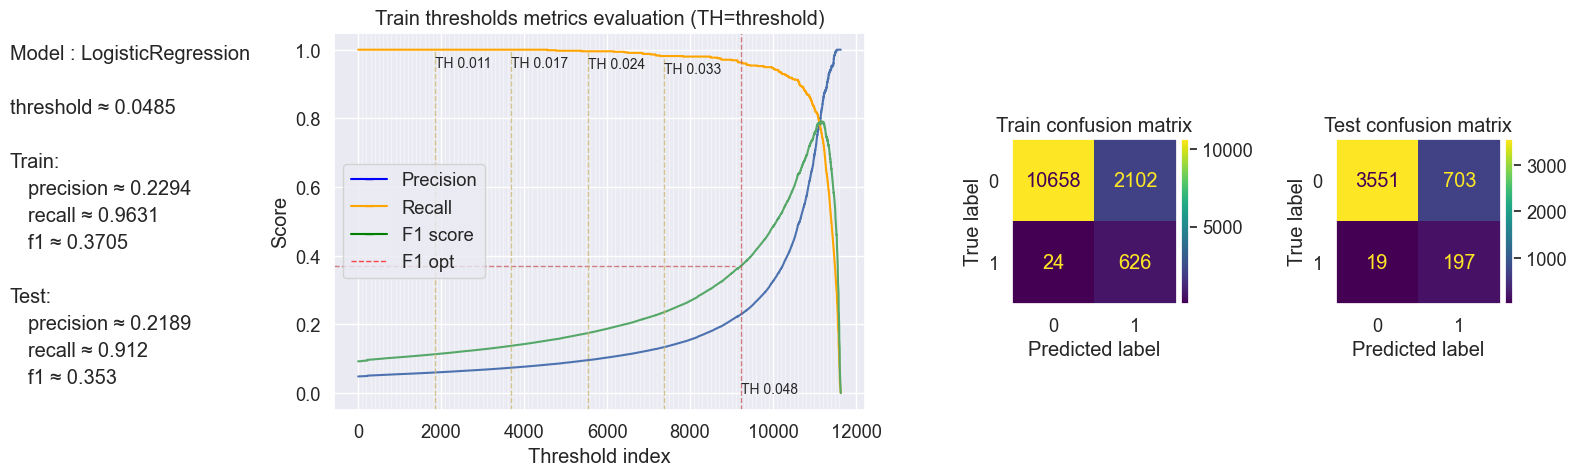

In [120]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.0485)
#storing this values to compare
compare_dict["Logistic tfidf"]["th_opt"]= values
print(values)

Text(0.9320370370370371, 0.21888888888888888, 'Threshold ≈ 0.0485\nf1-score ≈ 0.353')

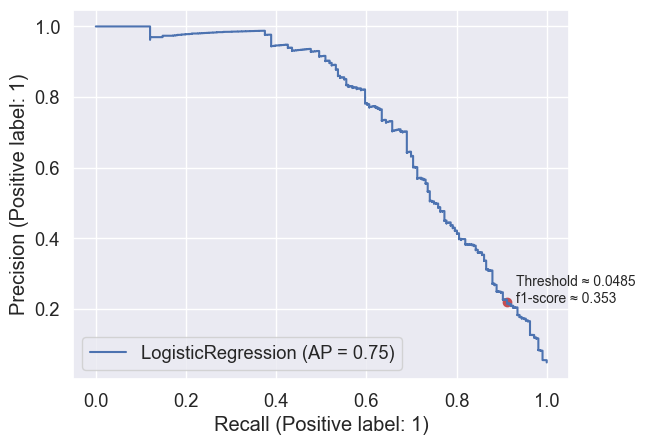

In [121]:
metrics.PrecisionRecallDisplay.from_estimator(clf_tfidf , X_tfidf_test, y_test) # AP = average precision
threshold_opt = values["params"]["threshold"]
recall = values["test"]["recall"]
f1score = values["test"]["f1"]
precision = values["test"]["precision"]
plt.scatter(recall, precision, color="r")
text_annot = f"Threshold ≈ {np.round(threshold_opt,4)}\nf1-score ≈ {np.round(f1score,4)}"
plt.annotate(text_annot, (recall+0.02, precision), size=10)


As a sanity check, it's a good idea to check what terms the textual model cares about when making its decision.

As we see below, it looks like our model learned some things, such as `aker` and `subsea` are terms that only shows in fraudulent job posts, so makes sense that they are *positive* predictors with high coefficients. Other curious term is the term 'our', it's a word that brings some engagement with the significance that something exists that is not the case in a fraudulent job post. 

Description example with term 'aker': Fining dining restaurant and lounge seeks EXPERIENCED and SERIOUS servers and bartenders to join the


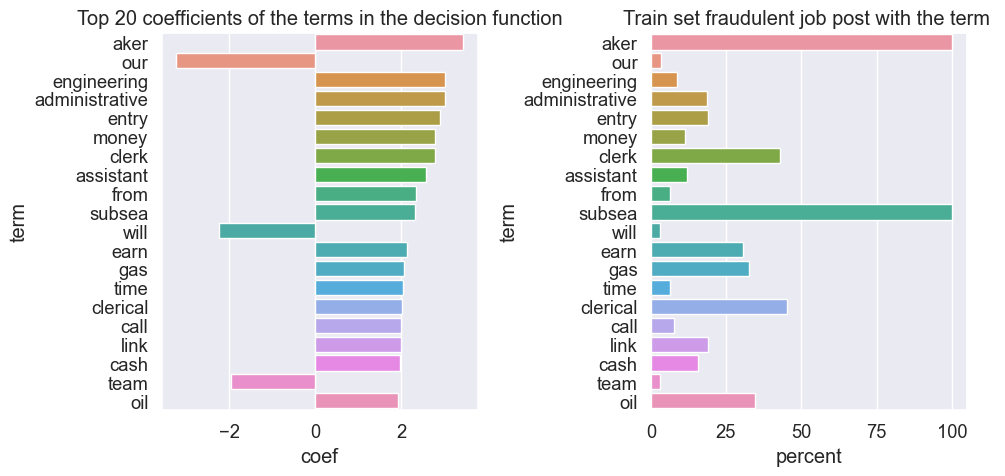

In [122]:
fig, (ax0, ax1) =  plt.subplots(ncols=2, figsize=(10,5))

print("Description example with term 'aker':", train_df_norm.loc[120,"description"][:100])

tfidf_coef_df = pd.DataFrame({'coef':clf_tfidf.coef_[0]})
tfidf_coef_df['term'] = tfidf.get_feature_names_out()
tfidf_coef_df['coef_abs'] = tfidf_coef_df['coef'].abs()
tfidf_coef_df = tfidf_coef_df.sort_values('coef_abs', ascending=False)
sns.barplot(y='term', x='coef', data=tfidf_coef_df[:20], ax=ax0).set(title="Top 20 coefficients of the terms in the decision function")


dict_fraudulent_terms = {col:  y_train[train_tfidf_df[col]!=0].mul(100).values.mean().round(2) for col in tfidf_coef_df["term"][:20]}
df_fraudulent_terms = pd.DataFrame(dict_fraudulent_terms.values(), index=dict_fraudulent_terms.keys(), columns=["percent"])

sns.barplot( y=df_fraudulent_terms.index, x=df_fraudulent_terms["percent"], ax=ax1).set(title="Train set fraudulent job post with the term ", xlabel="percent", ylabel="term");

plt.tight_layout()

#### Ngrams
An N-gram means a sequence of N words. So for example, “Medium blog” is a 2-gram (a bigram), “A Medium blog post” is a 4-gram, and “Write on Medium” is a 3-gram (trigram).

By including unigrams, bigrams or trigrams in the model, is more likely to capture important information that appears as multiple tokens in the text--for example, "account management".



##### Ngrams (1,2)

Bigrams

In [123]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,2))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, np.ravel(y_train))

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")


vectorize testing done in 23.022s 


As we can see we can achive a better results combining unigrams and bigrams, having $\approx$4% increase of recall and F1 score from previous model.

{'params': {'threshold': 0.5}, 'train': {'f1': 0.5102974828375286, 'precision': 0.9955357142857143, 'recall': 0.34307692307692306}, 'test': {'f1': 0.4609929078014184, 'precision': 0.9848484848484849, 'recall': 0.30092592592592593}}


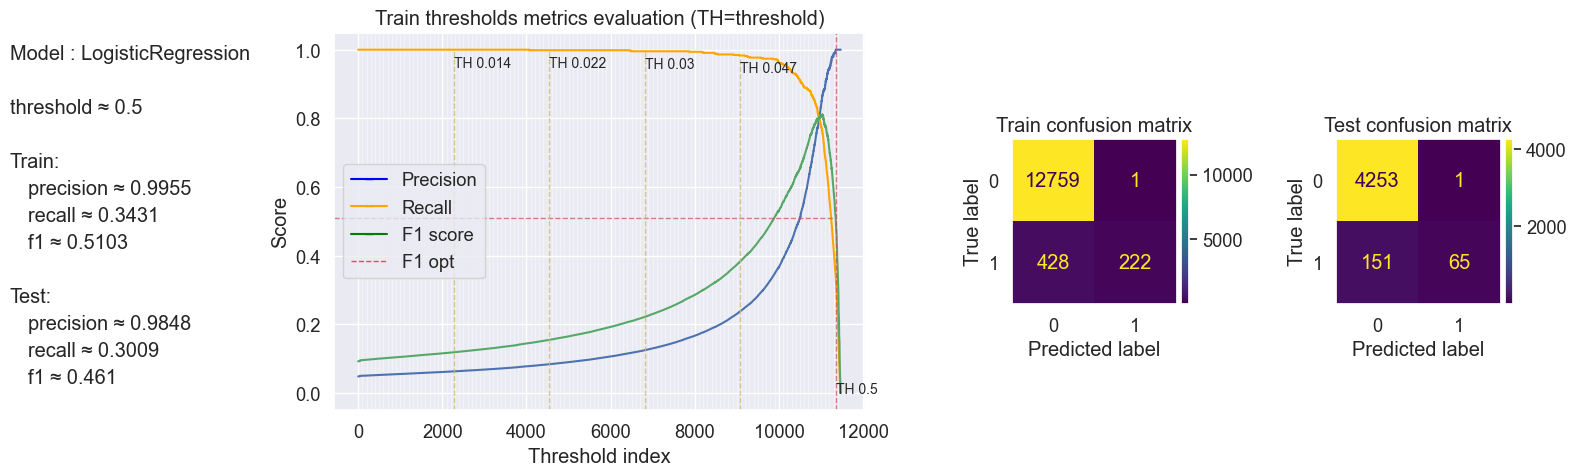

In [124]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic bigrams"]= {"default": values}
print(values)

Calculating the threshold based on max f1 score and inspecting the confusion matrix.
With a threshold of ≈0.1619 we have a good Recall, ≈62% of the true fraudulent job posts are predicted as fraudulent in our test, Precision is high as consequence we have a good F1-score, but his metrics is a little worse than in the experiment using online unigrams.

{'params': {'threshold': 0.16193888550303642}, 'train': {'f1': 0.8114285714285714, 'precision': 0.8643478260869565, 'recall': 0.7646153846153846}, 'test': {'f1': 0.690537084398977, 'precision': 0.7714285714285715, 'recall': 0.625}}


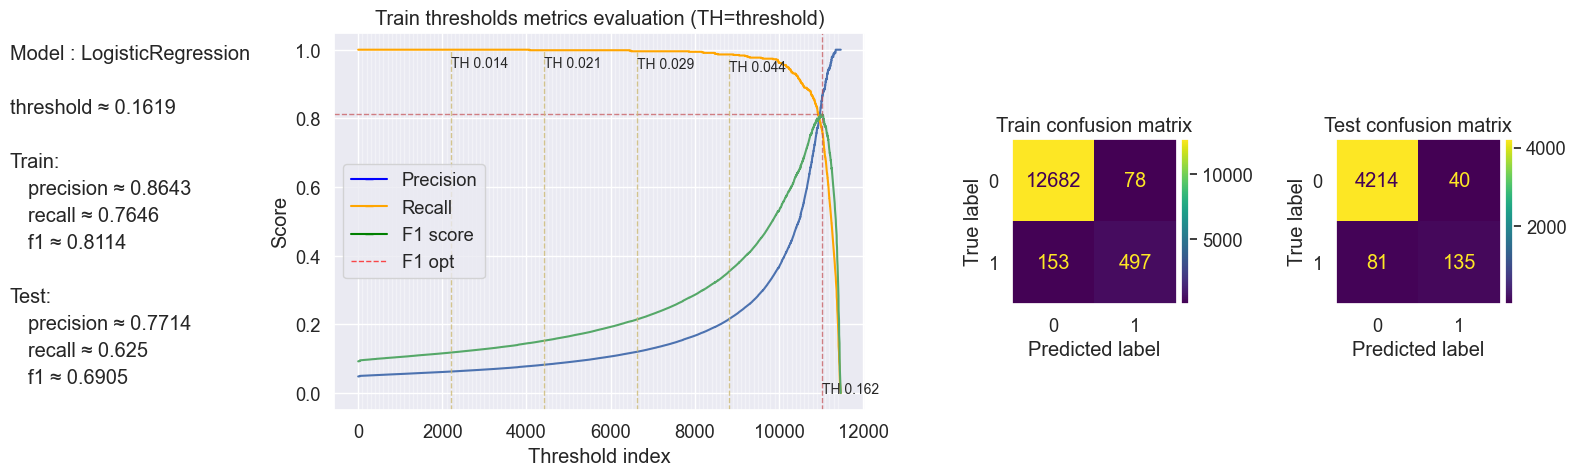

In [125]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True)
#storing this values to compare
compare_dict["Logistic bigrams"]["f1_opt"]= values
print(values)

Using the 0.0485 threshold we have great recall metric, ≈92% of the true fraudulent job posts are predicted as fraudulent in our test. Precision and F1 score are not so great but in this case better than using only unigrams with an increasing of 2% in our f1 score.

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.40252365930599365, 'precision': 0.25317460317460316, 'recall': 0.9815384615384616}, 'test': {'f1': 0.3747645951035781, 'precision': 0.23522458628841608, 'recall': 0.9212962962962963}}


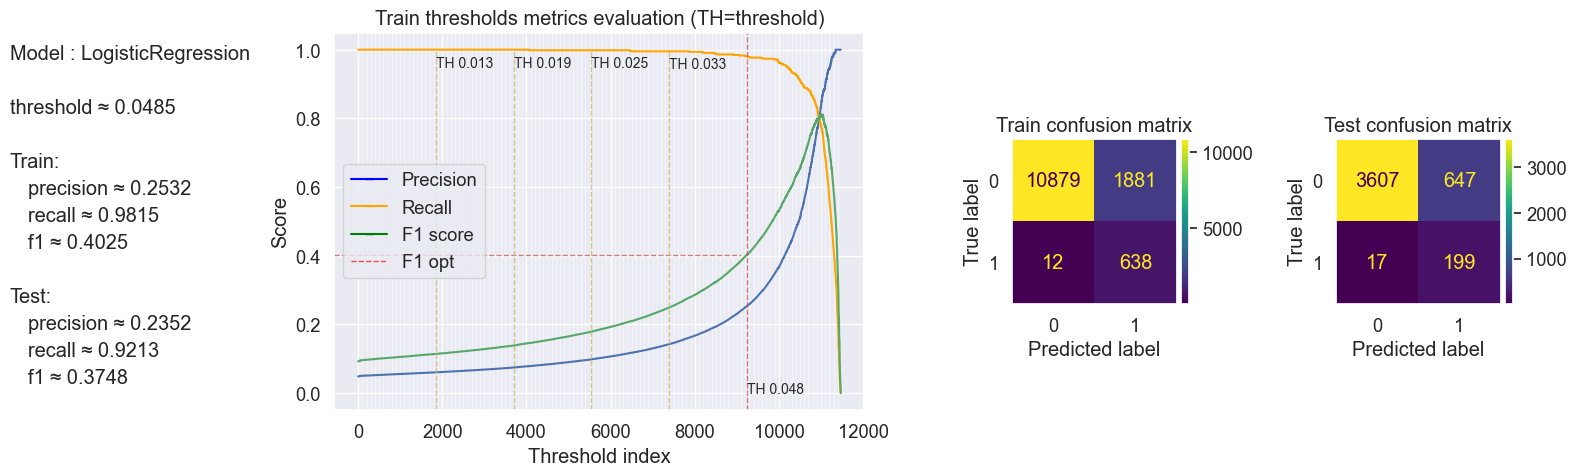

In [126]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.0485)
#storing this values to compare
compare_dict["Logistic bigrams"]["th_opt"]= values
print(values)

Let's check some unigram and bigram words:

In [127]:
print(train_tfidf_df.shape)
train_tfidf_df.sample(15, axis=1, random_state=42).head()

(13410, 25000)


developing deep  wire transfer  ...  service nvq  and would
0              0.0       0.051741  ...          0.0        0.0
1              0.0       0.000000  ...          0.0        0.0
2              0.0       0.000000  ...          0.0        0.0
3              0.0       0.000000  ...          0.0        0.0
4              0.0       0.000000  ...          0.0        0.0

[5 rows x 15 columns]

##### Ngrams (1,3)
Trigrams

In [128]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, np.ravel(y_train))

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")


vectorize testing done in 27.225s 


The scores are the same as combining unigrams and bigrams using the 0.5 threshold.

{'params': {'threshold': 0.5}, 'train': {'f1': 0.512, 'precision': 0.9955555555555555, 'recall': 0.3446153846153846}, 'test': {'f1': 0.4609929078014184, 'precision': 0.9848484848484849, 'recall': 0.30092592592592593}}


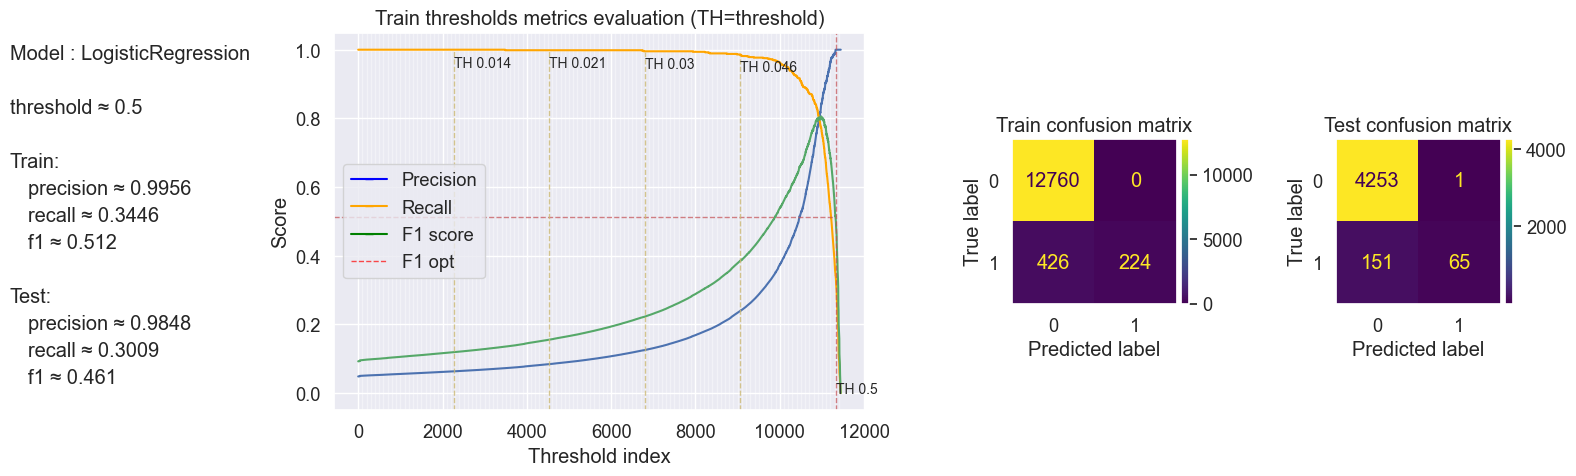

In [129]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic trigrams"]= {"default": values}
print(values)

Calculating the threshold based on max f1 score and inspecting the confusion matrix.
With a threshold of ≈0.1542 we have a better Recall than using only unigrams and bigrams, with a increase of 3% we have ≈65% of the true fraudulent job posts are predicted as fraudulent in our test, Precision is high as consequence we have a good F1-score, the best F1 score till now, with ≈0.71.

{'params': {'threshold': 0.15417957934023463}, 'train': {'f1': 0.8057784911717495, 'precision': 0.8422818791946308, 'recall': 0.7723076923076924}, 'test': {'f1': 0.7103274559193955, 'precision': 0.7790055248618785, 'recall': 0.6527777777777778}}


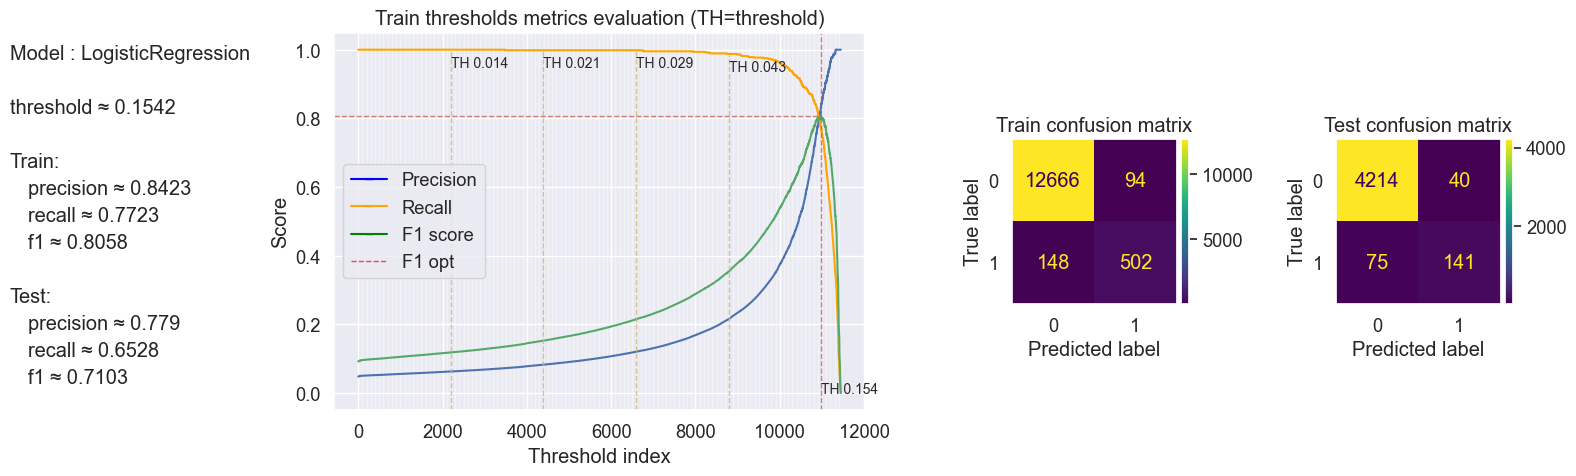

In [130]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True)
#storing this values to compare
compare_dict["Logistic trigrams"]["f1_opt"]= values
print(values)

Using the 0.0485 threshold we have great recall metric, ≈91.7% of the true fraudulent job posts are predicted as fraudulent in our test, although in this case the metrics have a litle worse scores than using bigrams. So we will stick with bigrams.

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.40586173940745457, 'precision': 0.25592607472880674, 'recall': 0.98}, 'test': {'f1': 0.3728813559322034, 'precision': 0.23404255319148937, 'recall': 0.9166666666666666}}


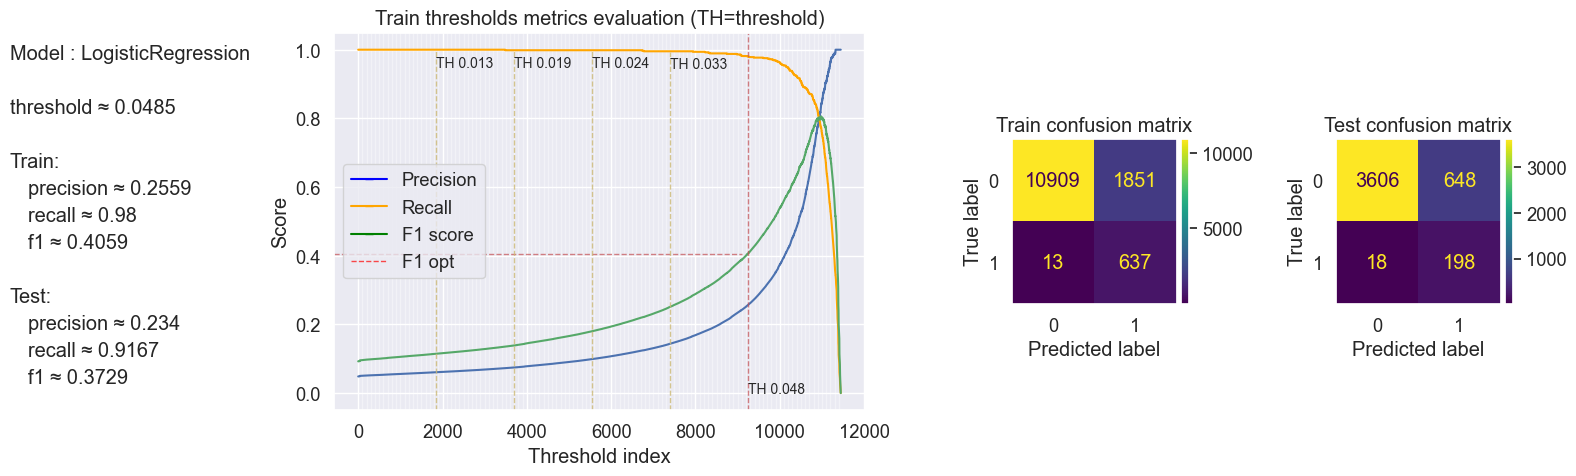

In [131]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.0485)
#storing this values to compare
compare_dict["Logistic trigrams"]["th_opt"]= values
print(values)

#### Lemmatization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.

Examples of lemmatization:
- rocks : rock
- corpora : corpus
- better : good

This did not improved our metrics. This idea will be abandoned.

In [132]:
# import these modules
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [133]:
from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36

wnl = WordNetLemmatizer()


def lemmatize_words(text):
    words = text.split()    
    words = [wnl.lemmatize(word) for word in words] 
    return ' '.join(words)

train_text_lem_col = train_text_col.apply(lemmatize_words)
test_text_lem_col = test_text_col.apply(lemmatize_words)


tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,2))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_lem_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_lem_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, y_train)

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")


vectorize testing done in 30.663s 


Using the 0.5 threshold at first sight we have worst scores than using the Ngrams, f1-score is ≈2% worse.

{'params': {'threshold': 0.5}, 'train': {'f1': 0.5102974828375286, 'precision': 0.9955357142857143, 'recall': 0.34307692307692306}, 'test': {'f1': 0.4444444444444444, 'precision': 0.9841269841269841, 'recall': 0.28703703703703703}}


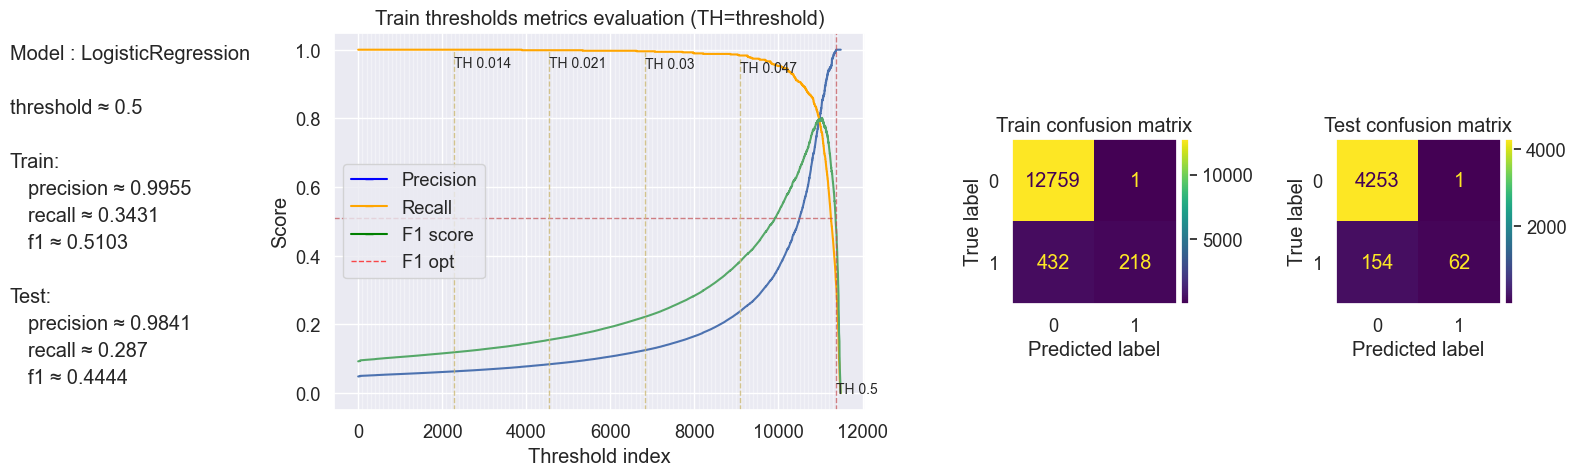

In [134]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic lem"]= {"default": values}
print(values)

Calculating the threshold based on max f1 score and inspecting the confusion matrix. Comparing with the bigrams we have a better recall and f1 score, with a threshold of ≈0.1614  we have an increase of ≈1% in the recall and ≈3% in the f1 score on our test set.

{'params': {'threshold': 0.16137392525357253}, 'train': {'f1': 0.8016260162601626, 'precision': 0.85, 'recall': 0.7584615384615384}, 'test': {'f1': 0.7168831168831168, 'precision': 0.8165680473372781, 'recall': 0.6388888888888888}}


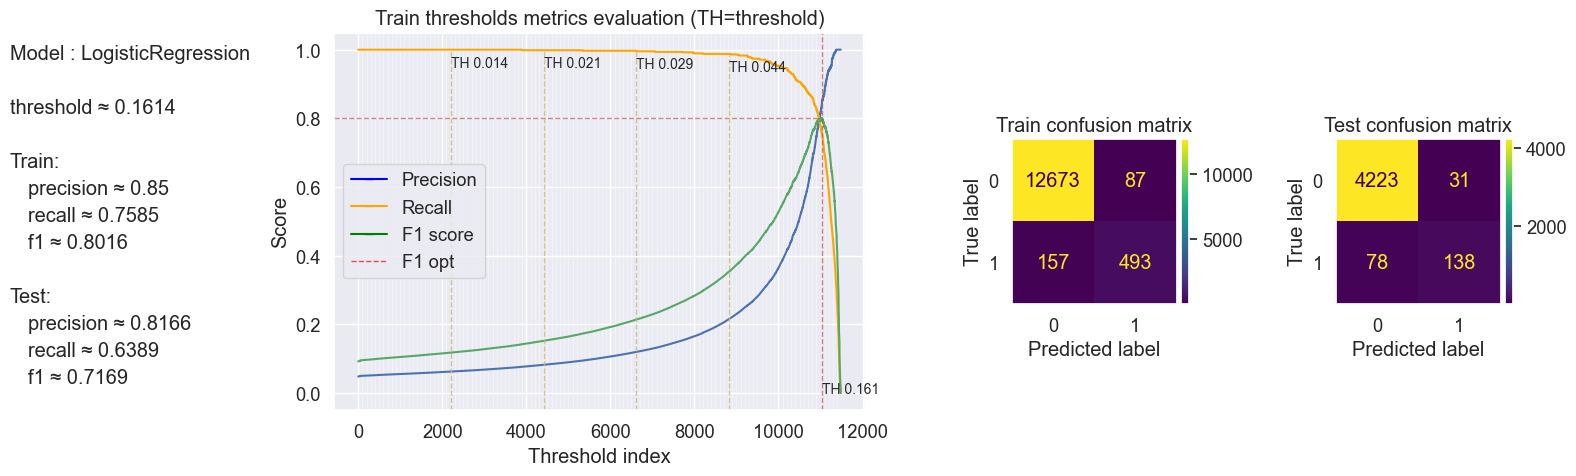

In [135]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True)
#storing this values to compare
compare_dict["Logistic lem"]["f1_opt"]= values
print(values)

Using the 0.0485 threshold we don't have a significant improvement in our metrics comparing with the bigrams experiment. With no clear advantage we will leave behind this idea.

{'params': {'threshold': 0.0485}, 'train': {'f1': 0.401760452687834, 'precision': 0.2524693796918214, 'recall': 0.9830769230769231}, 'test': {'f1': 0.3765373699148533, 'precision': 0.23662306777645659, 'recall': 0.9212962962962963}}


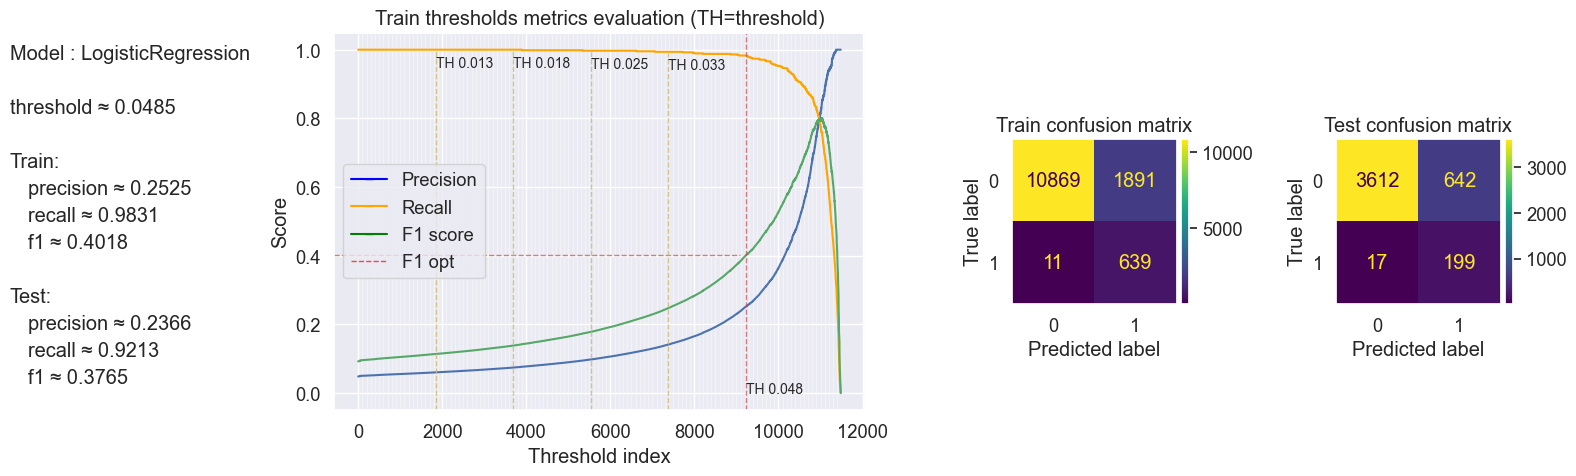

In [136]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.0485)
#storing this values to compare
compare_dict["Logistic lem"]["th_opt"]= values
print(values)

#### Oversampling

Perform over-sampling using `RandomOverSampler` from Imbalanced-learn library, over-sample the minority class(es) by picking samples at random with replacement. The bootstrap can be generated in a smoothed manner. [See Imbalanced-learn docs](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)

With a balanced train set we can now assume a Threshold of 0.5.
Oversampling the train dataset tends the model to overfit. Overfitting occurs when the model cannot generalize and fits too closely to the training dataset instead.
We can see that training metrics have perfect scores but test scores have poor results.

We will leave this idea and not use oversample.


In [137]:
from imblearn.over_sampling import RandomOverSampler

X_train = train_df_norm.drop(columns=TARGET_COL)
y_train = train_df_norm[TARGET_COL]

X_test = test_df_norm.drop(columns=TARGET_COL)
y_test = test_df_norm[TARGET_COL]

# Apply the random over-sampling
randover = RandomOverSampler(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = randover.fit_resample(X_train, y_train)
print("Before oversampling X train shape:",X_train.shape, np.mean(y_train) )
print("After oversampling X train shape:",X_train_resampled.shape, np.mean(y_train_resampled) )

Before oversampling X train shape: (13410, 22) fraudulent    0.048471
dtype: float64
After oversampling X train shape: (25520, 22) fraudulent    0.5
dtype: float64


In [138]:
train_text_col = X_train_resampled["title"] +" "+ X_train_resampled["description"] 
test_text_col = X_test["title"] +" "+ X_test["description"] 

from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,3))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

clf_tfidf = LogisticRegression(random_state = RANDOM_SEED)
clf_tfidf.fit(X_tfidf_train, np.ravel(y_train_resampled))

duration_test = time() - t0
print(f"vectorize testing done in {duration_test:.3f}s ")




vectorize testing done in 41.962s 


{'params': {'threshold': 0.5}, 'train': {'f1': 0.9926871012914268, 'precision': 0.9854803830707445, 'recall': 1.0}, 'test': {'f1': 0.702928870292887, 'precision': 0.6412213740458015, 'recall': 0.7777777777777778}}


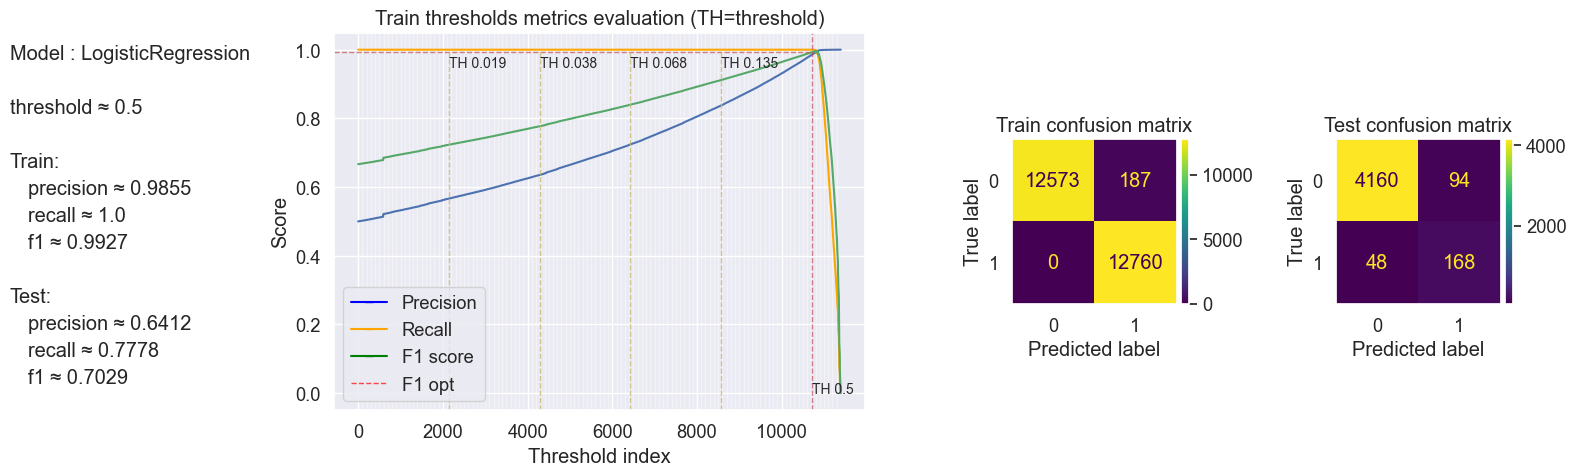

In [139]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train_resampled, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic oversamp"]= {"default": values}
print(values)

{'params': {'threshold': 0.5}, 'train': {'f1': 0.9926871012914268, 'precision': 0.9854803830707445, 'recall': 1.0}, 'test': {'f1': 0.702928870292887, 'precision': 0.6412213740458015, 'recall': 0.7777777777777778}}


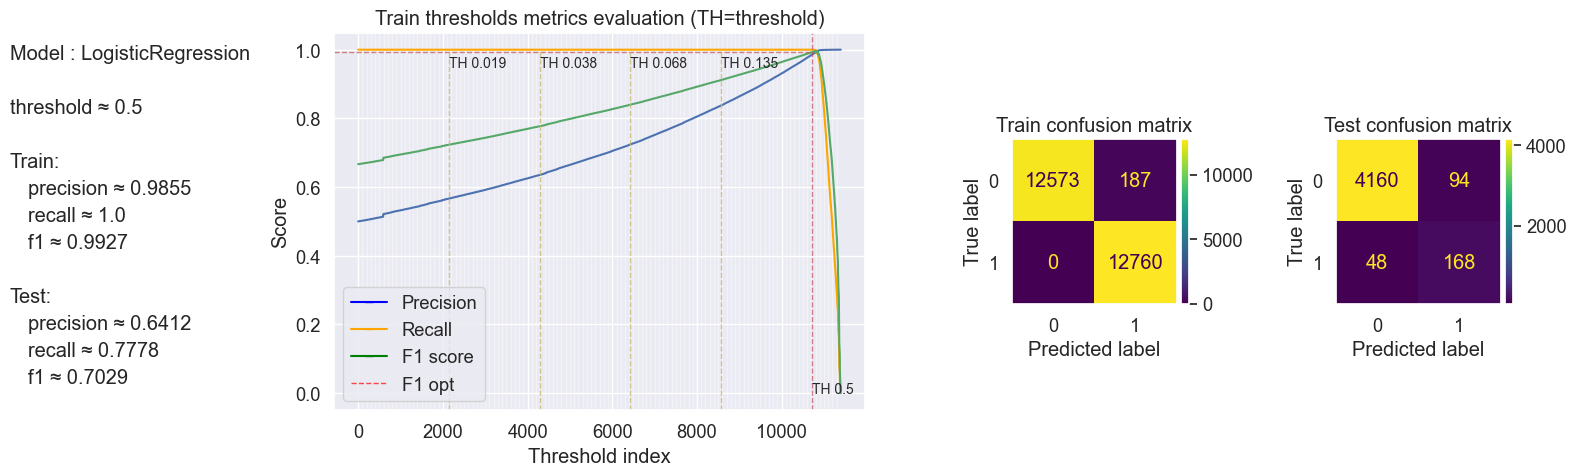

In [140]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train_resampled, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic oversamp"]["f1_opt"]= values
print(values)

{'params': {'threshold': 0.5}, 'train': {'f1': 0.9926871012914268, 'precision': 0.9854803830707445, 'recall': 1.0}, 'test': {'f1': 0.702928870292887, 'precision': 0.6412213740458015, 'recall': 0.7777777777777778}}


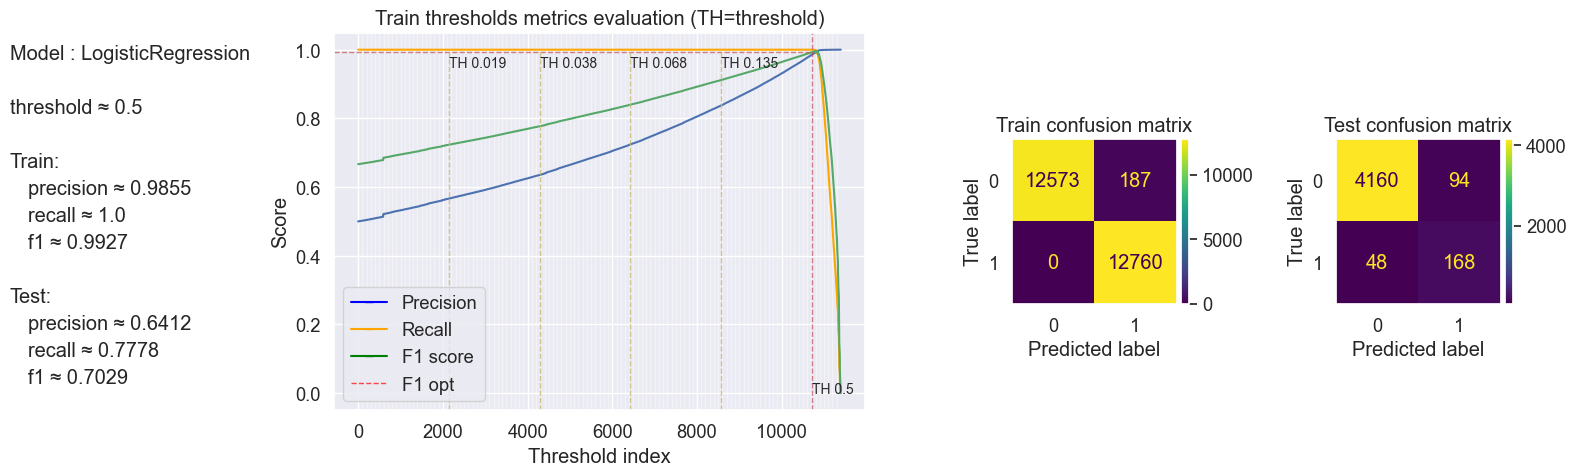

In [141]:
values = optimal_values(clf_tfidf, X_tfidf_train, y_train_resampled, X_tfidf_test, y_test, plot_charts=True, threshold_value=0.5)
#storing this values to compare
compare_dict["Logistic oversamp"]["th_opt"]= values
print(values)

#### Comparing metrics


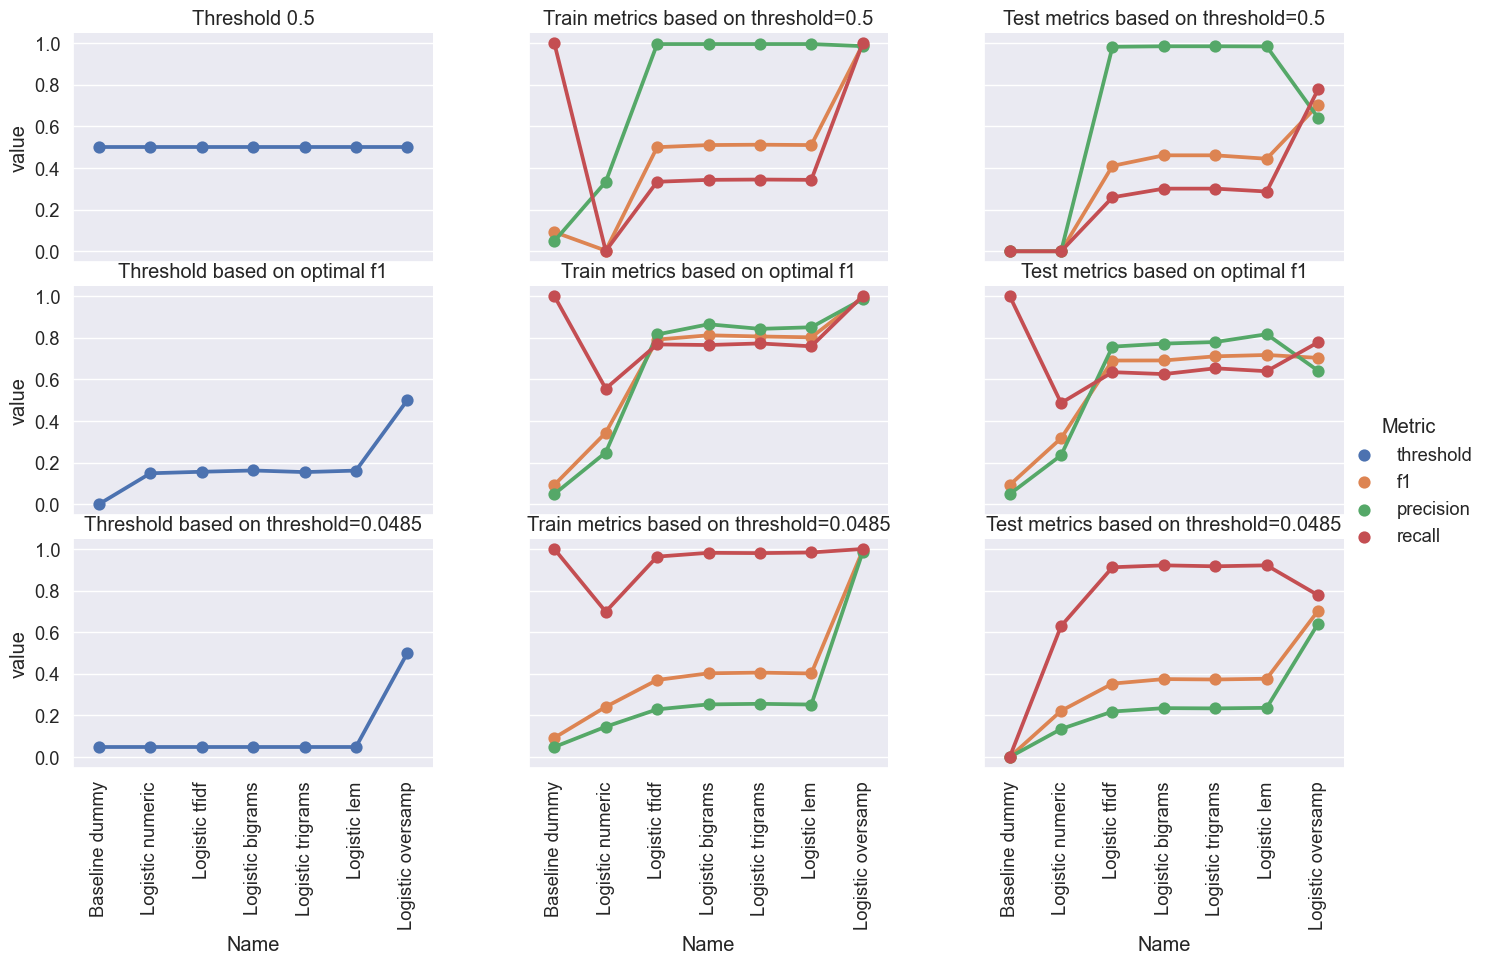

In [142]:

df_compare =pd.DataFrame.from_records(
    [
        (level1, level2, level3, level4, leaf)
        for level1, level2_dict in compare_dict.items()
        for level2, level3_dict in level2_dict.items()
        for level3, level4_dict in level3_dict.items()
        for level4, leaf in level4_dict.items()
    ],
    columns=['Name', 'Option', 'Attribute', 'Metric' , 'value']
)

# df_compare = df_compare.set_index(['Name', 'Option', 'Attribute']).head(20)

g = sns.catplot(data=df_compare, x="Name", y="value", hue="Metric", col="Attribute", row="Option", kind="point")
g.fig.set_figwidth(15)
g.fig.set_figheight(8)

[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat];


for (row_key, col_key),ax in g.axes_dict.items():
    title=""
    if col_key == "params":
        title1 = "Threshold"
    elif col_key == "train":
        title1 = "Train metrics"
    else:
        title1 = "Test metrics"
    if row_key == "default" and col_key == "params":
        title = title1 + " 0.5"
    elif row_key == "default":
        title = title1 + " based on threshold=0.5"
    elif row_key == "f1_opt":
        title = title1 + " based on optimal f1"
    else:
        title = title1 + " based on threshold=0.0485"
    ax.set_title(title)
# pd.DataFrame.from_dict(compare_dict, orient='index')

### Various Models

Will now test different models applying TfidfVectorizer with the hyperparameters:
- max_features=25000 
- token_pattern =  r"\b[a-zA-Z]\w{2,35}\b"
- ngram_range=(1,2)


In [143]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Neural Network': {
        'model': MLPClassifier(random_state = RANDOM_SEED, early_stopping=True),
        'metrics': {}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state = RANDOM_SEED),
        'metrics': {}
    }
}




In [144]:
# using tested transformations from examples avobe we construct the final train and test sets

X_train = train_df_norm.drop(columns=TARGET_COL)
y_train = train_df_norm[TARGET_COL]

X_test = test_df_norm.drop(columns=TARGET_COL)
y_test = test_df_norm[TARGET_COL]

train_text_col = X_train["title"] +" "+ X_train["description"] 
test_text_col = X_test["title"] +" "+ X_test["description"] 

from time import time
t0 = time()
PATTERN =  r"\b[a-zA-Z]\w{2,35}\b" # words that not starts with digits and words with len >2 and <= 36
tfidf = TfidfVectorizer(max_features=25000, token_pattern=PATTERN, ngram_range=(1,1))
tfidf.fit(train_text_col)
train_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(train_text_col), columns=tfidf.get_feature_names_out())
test_tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.transform(test_text_col), columns=tfidf.get_feature_names_out())

X_tfidf_train = train_tfidf_df.sparse.to_coo()
X_tfidf_test = test_tfidf_df.sparse.to_coo()

In [145]:
# we will train using the different models and store the metrics
from time import time
threshold = 0.0485

for k, v in classifiers.items():
    t0 = time()    
    model = v["model"]
    print("Working the model", model.__class__.__name__,"...")
    model.fit(X_tfidf_train, np.ravel(y_train))    
    _, _, test_f1score, test_recall, test_precision = f1_recall_precision_threshold(model, X_tfidf_test, y_test)
    values  = optimal_values(model, X_tfidf_train, y_train, X_tfidf_test, y_test, threshold_value= threshold )
    threshold_opt =  values["params"]["threshold"]
    opt_recall = values["test"]["recall"]
    opt_f1score = values["test"]["f1"]
    opt_precision = values["test"]["precision"]    
    duration_test = time() - t0
    v["metrics"] = {"test precision":test_precision, 
                    "test recall":test_recall, 
                    "test f1":test_f1score,
                    "opt threshold":threshold_opt, 
                    "test opt precision":opt_precision, 
                    "test opt recall":opt_recall, 
                    "test opt f1":opt_f1score, 
                    "exec_time":duration_test}     
    print(f"Model done in {duration_test:.3f}s\n")

df_metrics = pd.DataFrame([{"model":k, **{ mk:mv  for mk, mv in v["metrics"].items()  }} for k, v in classifiers.items()   ])

Working the model LogisticRegression ...
Model done in 10.938s

Working the model DecisionTreeClassifier ...
Model done in 26.486s

Working the model RandomForestClassifier ...
Model done in 12.490s

Working the model MLPClassifier ...
Model done in 295.177s

Working the model AdaBoostClassifier ...
Model done in 10.077s

Working the model GradientBoostingClassifier ...
Model done in 39.303s



In [146]:
df_metrics = df_metrics.sort_values("test opt recall", ascending=False)
df_metrics

model  test precision  ...  test opt f1   exec_time
4             AdaBoost        0.687500  ...     0.092190   10.077329
0  Logistic Regression        0.982456  ...     0.353047   10.937702
2        Random Forest        0.991935  ...     0.397927   12.490194
3       Neural Network        0.953333  ...     0.641441  295.177136
5    Gradient Boosting        0.944444  ...     0.639175   39.302656
1        Decision Tree        0.676056  ...     0.671329   26.486268

[6 rows x 9 columns]

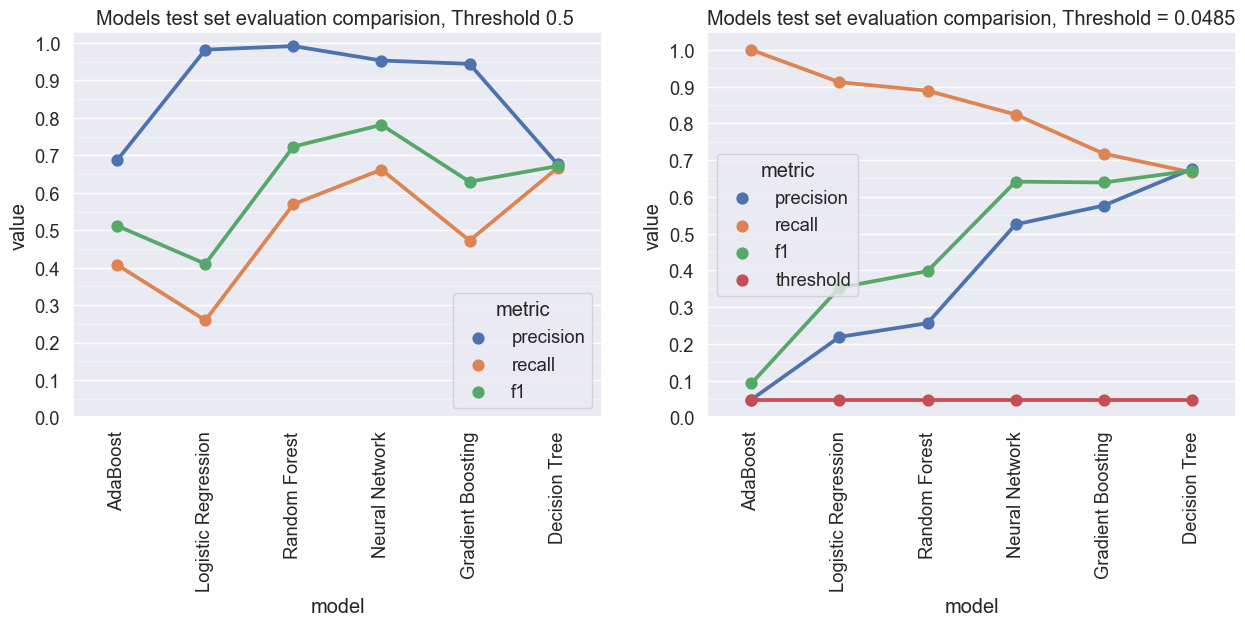

In [147]:
fig,(ax0, ax1) = plt.subplots(ncols=2, figsize=(15,5))

df_metric_melt=pd.melt(df_metrics, id_vars=["model"],value_vars=["test precision","test recall","test f1"], var_name="metric",value_name="value" )
df_metric_melt["metric"] = df_metric_melt["metric"].replace({"test precision":"precision","test recall":"recall","test f1":"f1"})

ax= sns.pointplot(data=df_metric_melt, x="model", y="value", hue="metric", ax= ax0)
ax.set(title="Models test set evaluation comparision, Threshold 0.5 ")
major_tick = np.arange(0, 1.01, 0.1)
minor_tick = np.arange(0, 1.01, 0.05)
ax.set_yticks(major_tick)
ax.set_yticks(minor_tick, minor=True)
ax.grid(visible=True, which='major', axis="y")
ax.grid(visible=True, which='minor',axis="y", alpha=0.4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

df_metric_melt=pd.melt(df_metrics, id_vars=["model"],value_vars=["test opt precision","test opt recall","test opt f1","opt threshold"], var_name="metric",value_name="value" )
df_metric_melt["metric"] = df_metric_melt["metric"].replace({"test opt precision":"precision","test opt recall":"recall","test opt f1":"f1","opt threshold":"threshold"})

ax= sns.pointplot(data=df_metric_melt, x="model", y="value", hue="metric", ax=ax1)
ax.set(title="Models test set evaluation comparision, Threshold = 0.0485")
ax.set_yticks(major_tick)
ax.set_yticks(minor_tick, minor=True)
ax.grid(visible=True, which='major', axis="y")
ax.grid(visible=True, which='minor',axis="y", alpha=0.4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);



## Part 1 conclusion

When we apply the "threshold-moving" technique we can get better metrics results.

Neural Network, Random Forest and Logistic Regression looks promissing, specially the Neural Network because gives a great recall value and also a great f1 score, this using default hyperparameters and using the threshold 0.0485.

By utilizing Ngrams, unigrams and bigrams, and adjusting the threshold, we were able to achieve satisfactory scores in our evaluation metrics using a basic Logistic Regression model. By setting the threshold at ≈0.0485, we were able to achieve a recall of ≈0.92, indicating that ≈92% of fraudulent jobs in the test set were correctly identified as fraudulent, which is a positive step towards resolving the problem at hand.


# Next...

In part 2 of this series we will be setting up version control and a tracking system, in this part the project is prepared for version control and tracking of experiments, by setting up tools such as DagsHub, DVC, and MLFlow. These tools can help to maintain a clear history of the project, track experiments, compare models and results, and collaborate with other team members.
